<a id=contents></a>

# Exploratory Data Analysis
## Our clean data at a glance


[1. Visualizing and exploring the Job Title field](#insp)

[2. Text EDA of both categories](#one)

[3. Salary EDA](#two)

[4. EDA 3](#three)

[5. Conclusions and ideas going forward](#conc)

In [550]:

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
import string
# !pip install wordcloud
import wordcloud
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)

import warnings
warnings.filterwarnings('ignore')


import functions as fn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
stop_word_lst = fn.gen_stopwords(['engineer', 'scientist', 'software'])

<a id=insp ><a/> 

## 1. Visualizing and exploring the Job Title field
    
[LINK to table of contents](#contents)

The job title field is a good starting point for our exploration because it's normally the first thing that someone exploring jobs will see (right before the salary) and tends to be a synthesis of the role in a few words. We'll be doing the EDA for this separately because we don't always wish to remove any stop words. The reason behind that is that job titles are limited in length and are less likely to contain uninformative words - each word that was purposefully put in there is significant, so we'll be passing an empty list to our stopword filtering parameter. Having said all that, analysing the titles will have great limitations because there's likely to be huge overlap (how many job posts will just have 'Data Scientist' in the title mixed in with some other words?). It'll be more difficult to pick out nuances from the title, and the description field will tell us more about what people can expect to be doing in their day-to-day role and what experience they might need.  

In [4]:
df = pd.read_csv('jobs.csv', )
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,company,job_title,job_descr,job_url,searched__data_scientist,searched__machine_learning_engineer,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews,id
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,would like reassure all applicant that recruit...,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,39853.0,21.00,Y,18.0,0
1,PwC,Deals - Investigative Analytics - Data Scienti...,career within Forensics Technology service wil...,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,NaN,NaN,NaN,7678.0,1
2,Capital One - UK,Data Scientist - Cyber,White Collar Factory 95009 United Kingdom Lond...,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0,NaN,NaN,NaN,8902.0,2
3,Globant,Lead Data Scientist,are digitally native technology where innovati...,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0,NaN,NaN,NaN,NaN,3
4,UK Government - National Crime Agency,G4 Lead Data Scientist - Cyber,Deploy analytical capability support operation...,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0,35846.0,18.89,Y,32.0,4


In [377]:
df.job_descr.duplicated().value_counts()

False    1052
True      173
Name: job_descr, dtype: int64

In [379]:
df.job_descr.drop_duplicates(inplace=True)

In [381]:
df.job_descr.nunique()

1052

We start of by plotting the unigram term frequecy across all DS and ML jobs. It's unsurprising that 'Data' and 'Engineer' come up at such high places with over 450 occurences. This grap isn't necessarily giving us that much information, because most of these are buzzwords on their own. We can start to make sense by looking at bigrams further below.

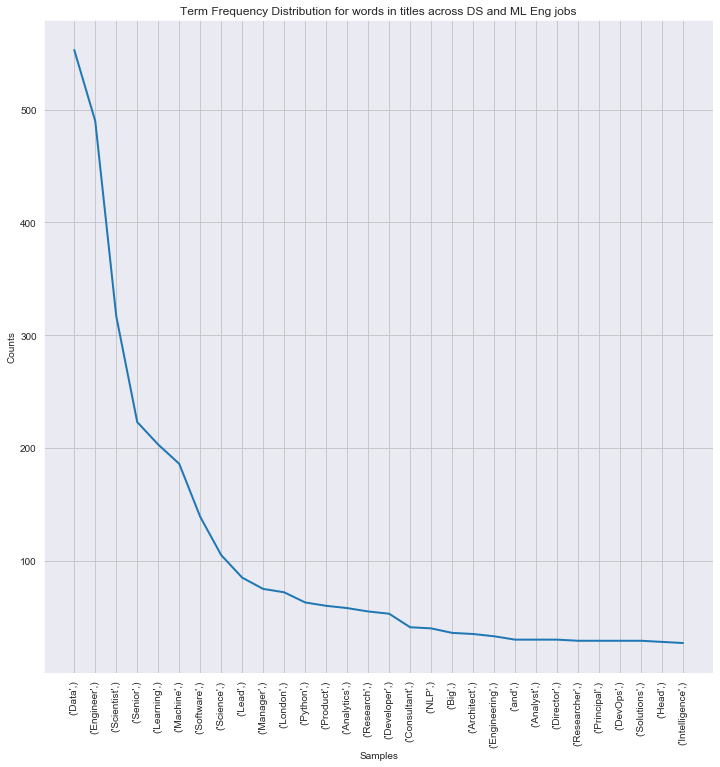

In [382]:
fn.plot_freqdist_from_series(df.job_title, tokenizer, [], 'Term Frequency Distribution for words in titles across DS and ML Eng jobs', figsize=(12,12), num_terms=30, lower_case=False);

A few more unsurprising leads come up with 'Data Scientist' and 'Machine Learning' being at the very top. This is not as informative because these are explicitly the categories we were already looking at and scraping for. However, lower down the list we find other more useful info, e.g. 'Product Manager', 'Computer Vision'. Nevertheless, buzzword terms and titles are dominating the distribution. Let's try plotting bigrams again with stopword filtering. I modified the stopword list in the functions.py file to include punctuation as well as 'scientist', 'engineer' and other redundant terms.

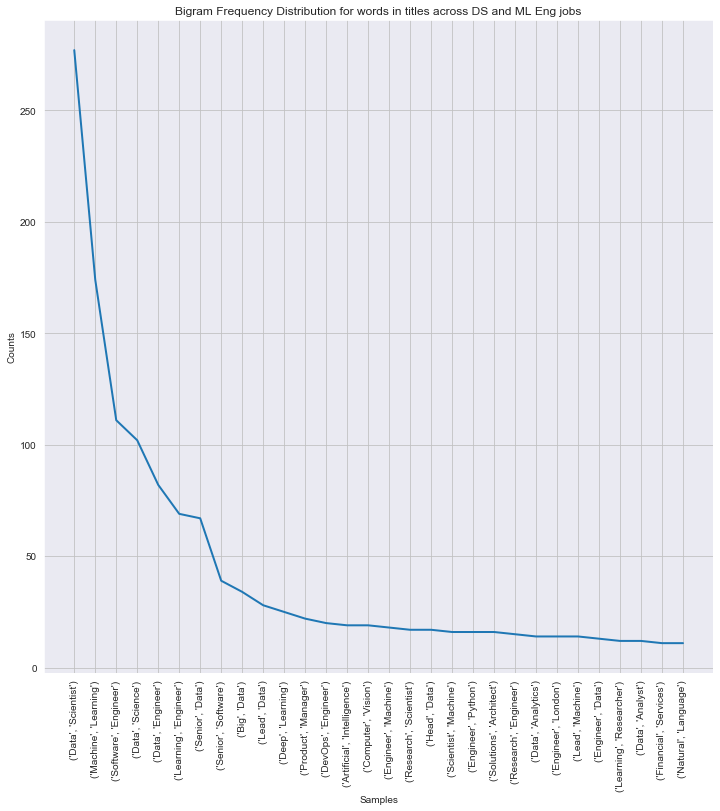

In [383]:
fn.plot_freqdist_from_series(df.job_title, tokenizer, [], 'Bigram Frequency Distribution for words in titles across DS and ML Eng jobs', 
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);

Now we can identify the total number of bigrams for these more unique combinations. 'Product Manager' clocks in at 22, 'Computer Vision' at 19. This is nevertheless dwarfed by the previous bigrams we had, which were an order of magnitude higher in frequency. Given that we have just over 1000 unique job descriptions, 'Product Manager' appears in roughly 2% of job posts, hardly a significant trend. 'Computer Vision' appears in even less so **if** this sampling of job descriptions is representative of the job market trends (which is a big _if_) computer vision jobs are not in a lot of demand right now.

Some terms are not coming up as intended though ('natural language' and 'language processing') and seem to have been truncated - we'll plot trigrams next to try to determine these. 

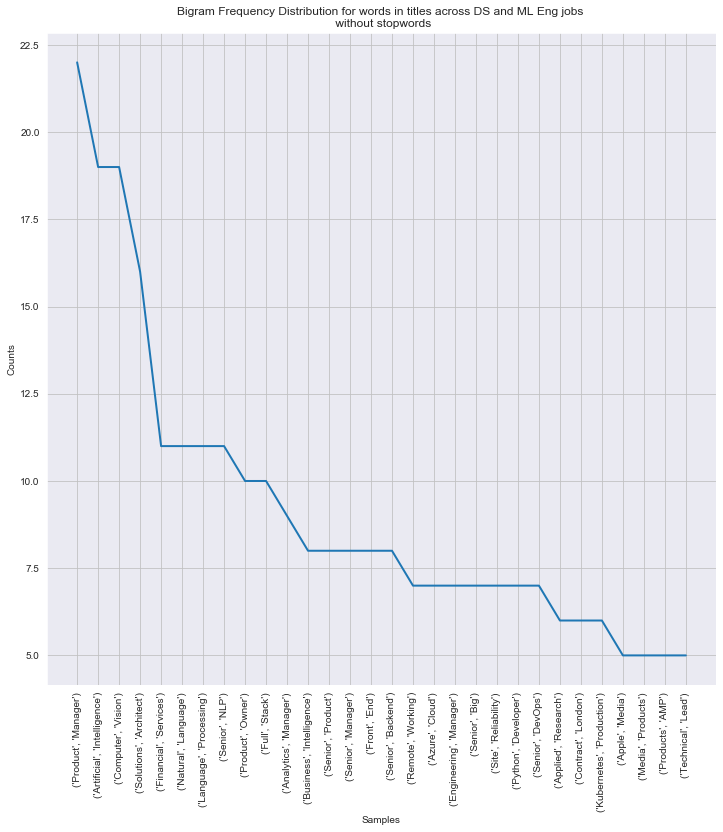

In [384]:
fn.plot_freqdist_from_series(df.job_title, tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in titles across DS and ML Eng jobs \n without stopwords', 
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);

For trigrams without stopwords we see different contenders cropping up, but 'Natural language processing' only registers at around 12, so barely 1% of the job titles. It's worth noting that at this point we start to see outliers like 'Full Stack Developer' and 'Scientific Writing Advocacy'. Whilst they are neither Data Scientist nor ML Engineering jobs, I can see why they would come up for those search terms. The trigrams with stopwords included gave us more information at this point. 

For someone like me it's promising to see that 'Senior Data Scientist' only covers about 5% of the job posts - it's also a bit worrying that 'Junior Data Scientist' doesn't even appear in the top 30 trigrams.

Next we should look at how this changes when we plot the Frequency distributions separately for DS and for ML Engineer searches.

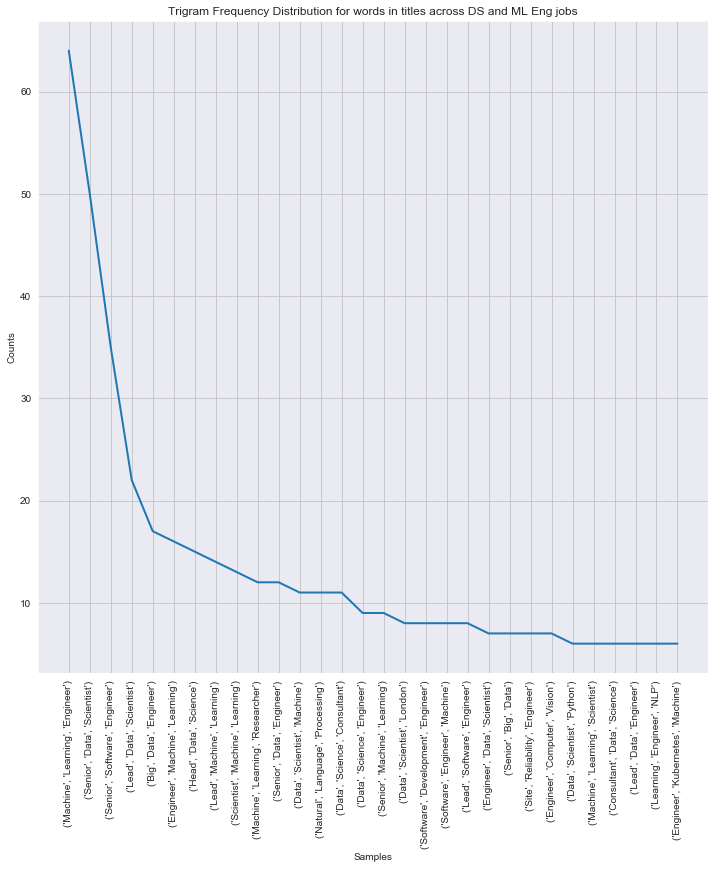

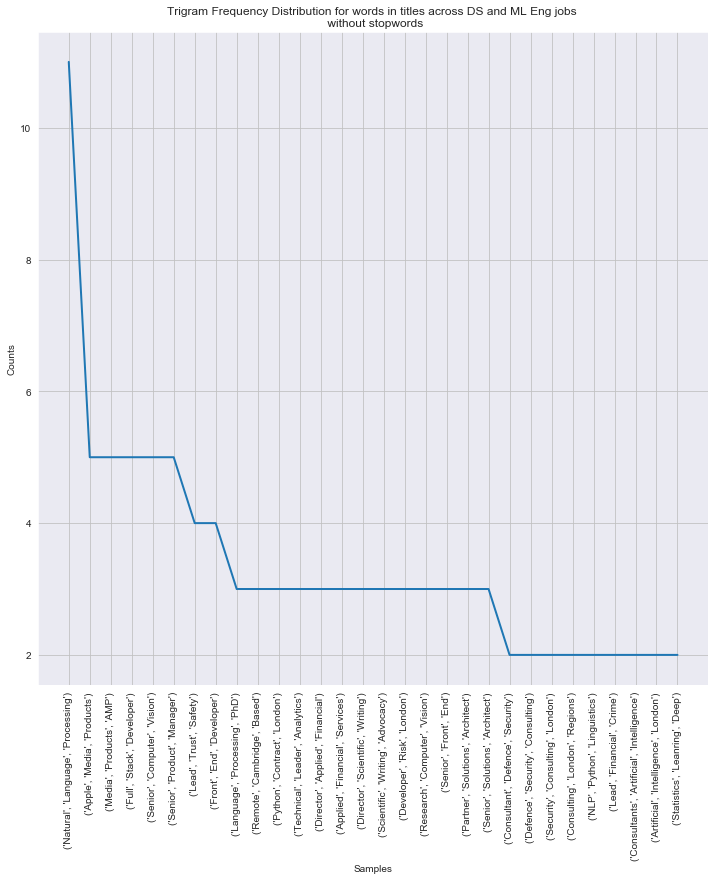

In [399]:
fn.plot_freqdist_from_series(df.job_title, tokenizer, [], 'Trigram Frequency Distribution for words in titles across DS and ML Eng jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);
fn.plot_freqdist_from_series(df.job_title, tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in titles across DS and ML Eng jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);

And now we begin to see that 'Senior' employees are in higher demand (15-20%) across both jobs, albeit more in Machine Learning Engineer jobs than DS. Again, single words don't give as much information, so we're better off looking at brigrams and trigrams.

In [400]:
print('Total DS jobs     = ', len(df.loc[df.searched__data_scientist==1].job_title))
print('Total ML Eng jobs = ', len(df.loc[df.searched__data_scientist==0].job_title))

Total DS jobs     =  545
Total ML Eng jobs =  680


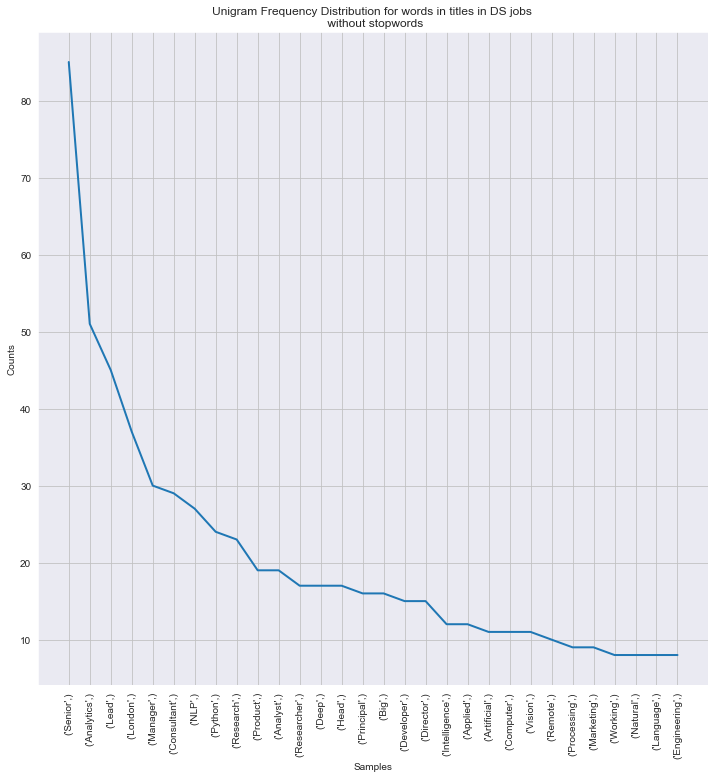

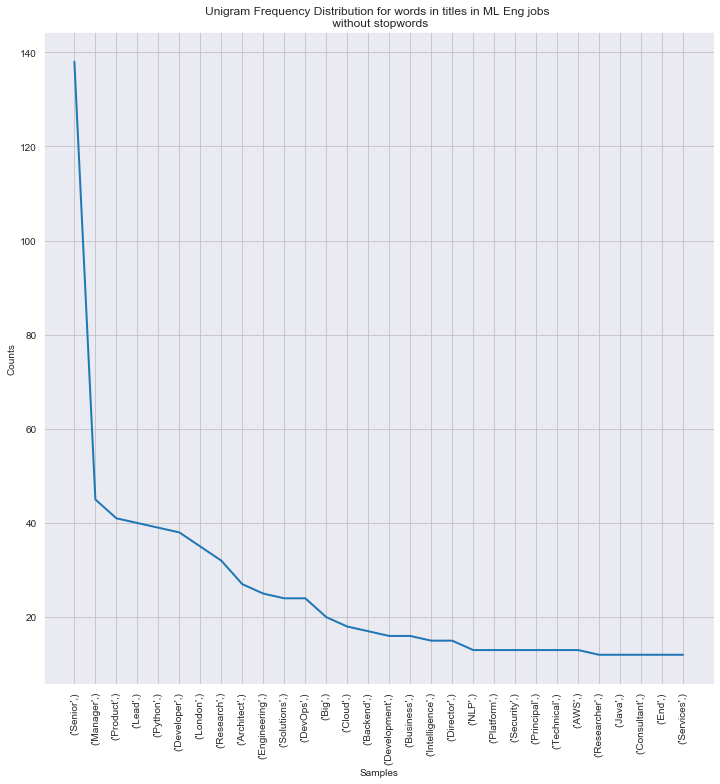

In [398]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, stop_word_lst, 'Unigram Frequency Distribution for words in titles in DS jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=1);
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==0].job_title, tokenizer, stop_word_lst, 'Unigram Frequency Distribution for words in titles in ML Eng jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=1);

The most surprising term is the 'Product Manager' at around 15% in ML Eng job posts - perhaps an indication that team leader and managerial roles are more in demand in this sample of ML jobs than they are in DS. 

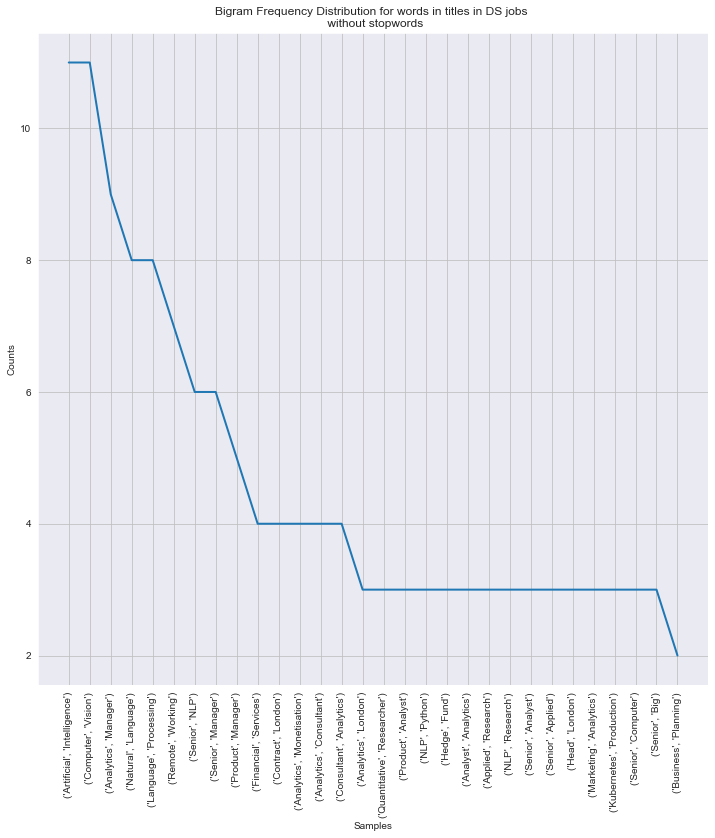

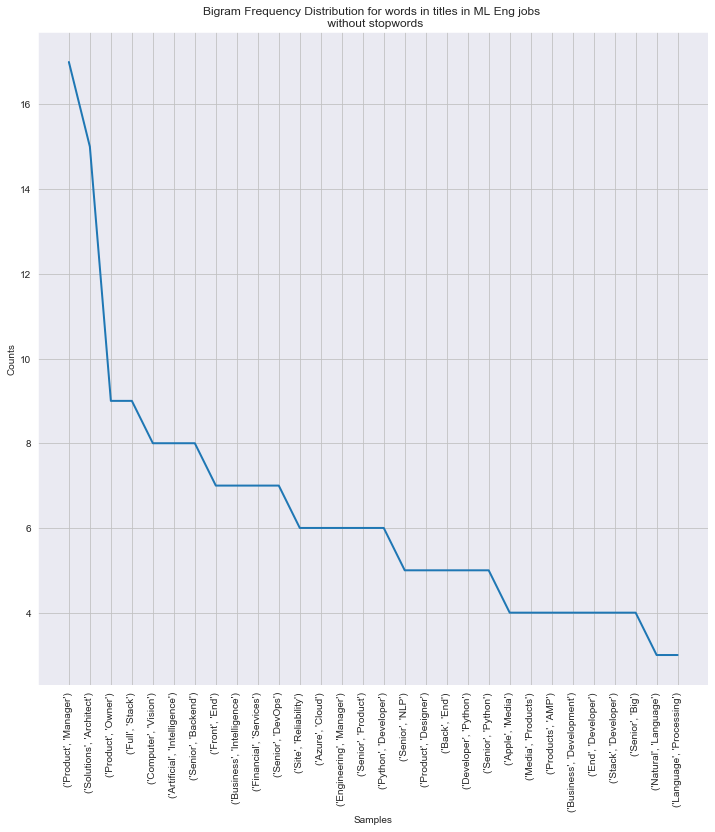

In [402]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in titles in DS jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==0].job_title, tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in titles in ML Eng jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);

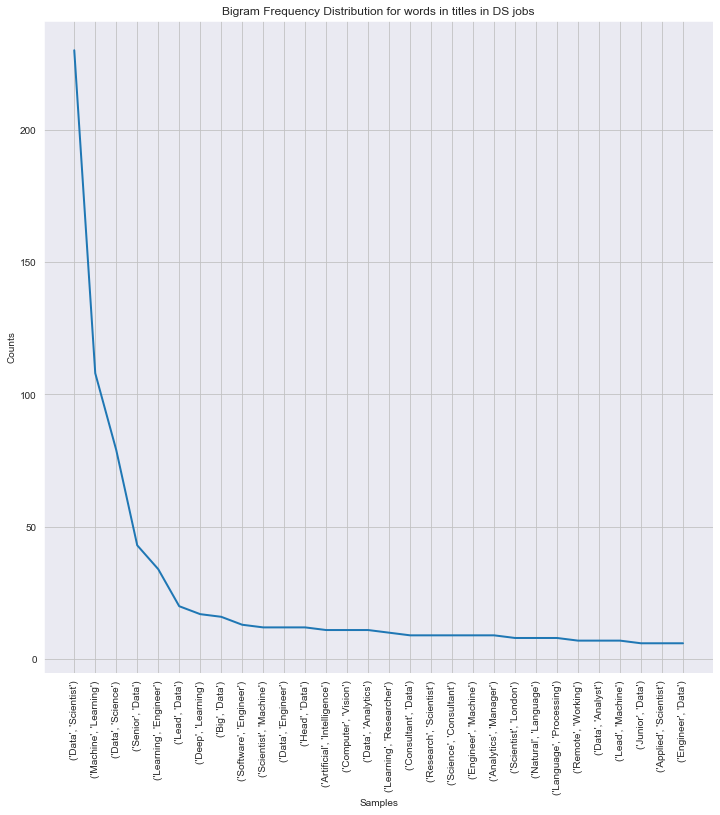

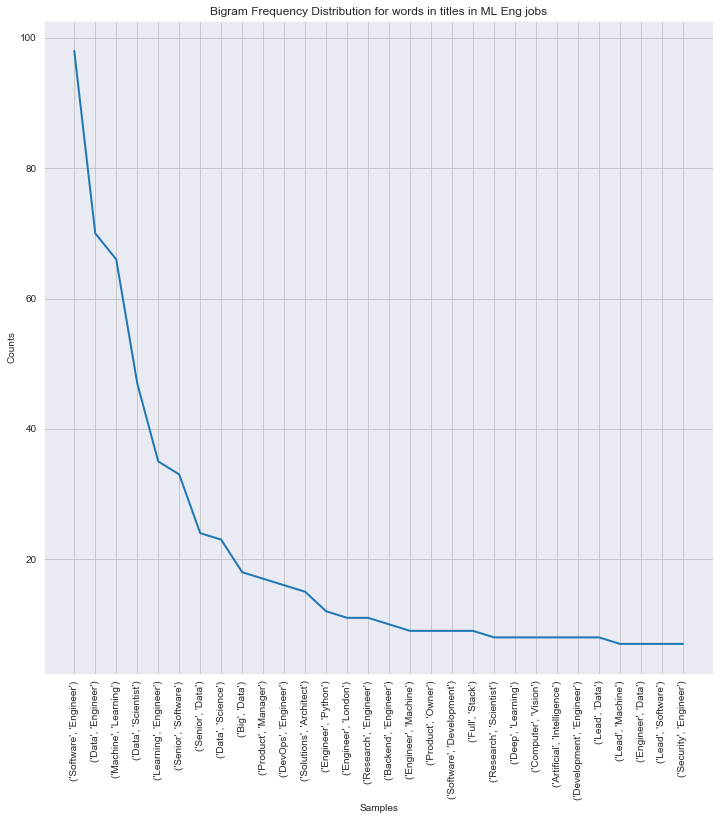

In [446]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, [], 'Bigram Frequency Distribution for words in titles in DS jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==0].job_title, tokenizer, [], 'Bigram Frequency Distribution for words in titles in ML Eng jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=2);

The only terms of significance cropping up consistently are titles with 'Senior' in them - a worrying term if you're just starting out in your DS or MLeng career! However, this is still in less than 10% of jobs. It's also worth reminding ourselves that that doesn't mean the rest of the job pots *don't* require a lot of experience - plenty of jobs will mention some years of prior work (or mention needing a doctorate degree).

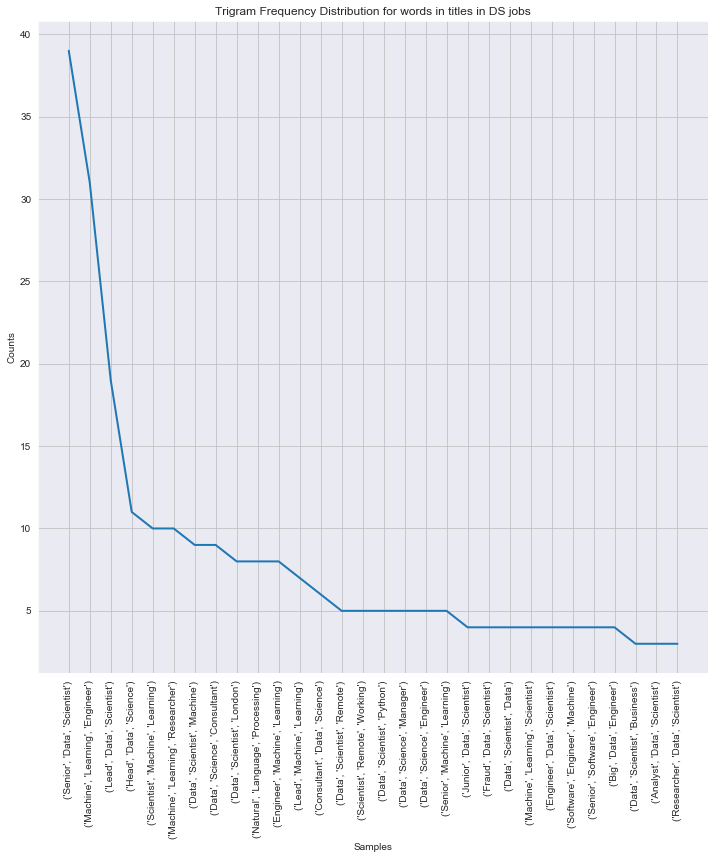

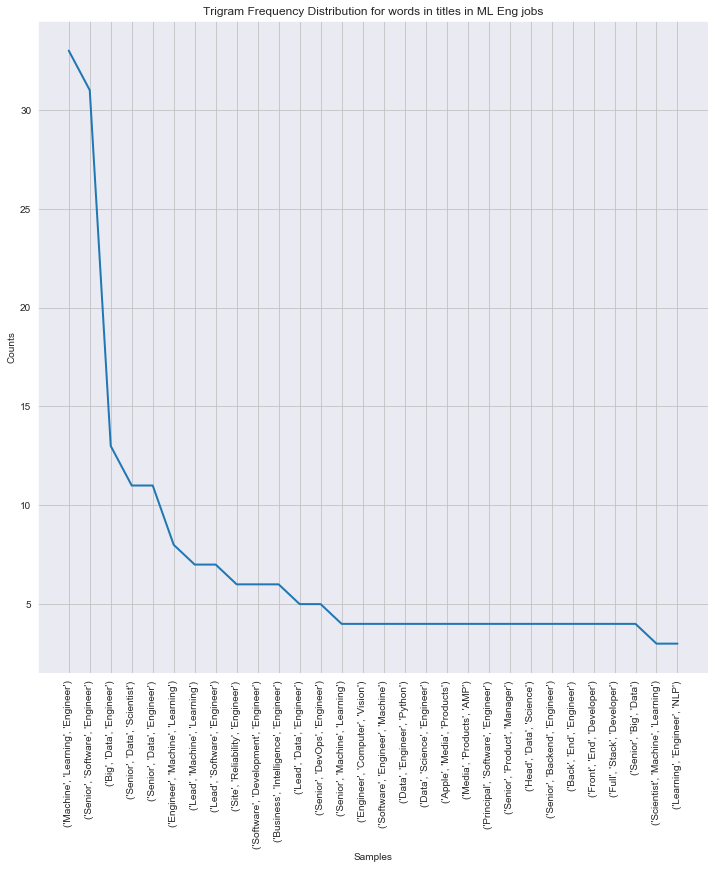

In [405]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, [], 'Trigram Frequency Distribution for words in titles in DS jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==0].job_title, tokenizer, [], 'Trigram Frequency Distribution for words in titles in ML Eng jobs',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);

Straight off the bat from looking at the distributions the severely positive skew in DS shows that we're reaching the end of informative ngrams here (at least without the stopword filtering). On the ML Eng side, it seems as if we're approaching niche terms, since individual companies ('Apple') are coming up. We've exhausted regular ngrams, but as a final step we want to check acronyms, since it's an industry domnated by them. 

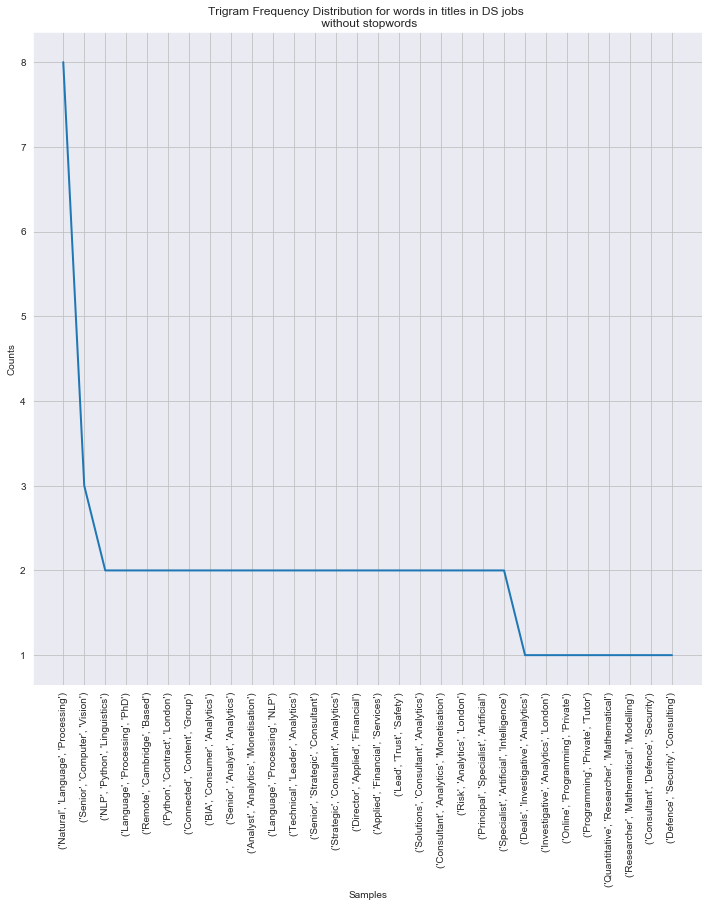

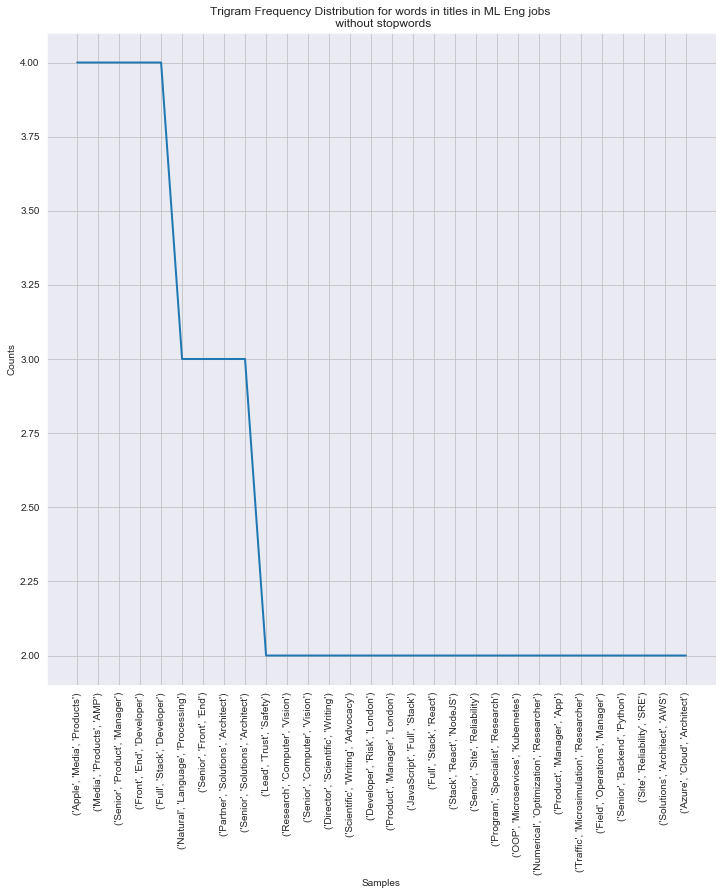

In [403]:
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==1].job_title, tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in titles in DS jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);
fn.plot_freqdist_from_series(df.loc[df.searched__data_scientist==0].job_title, tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in titles in ML Eng jobs \n without stopwords',
                             figsize=(12,12), num_terms=30, lower_case=False, ngram_number=3);

And we can see now just how prevalent using the buzzword 'AI' is - not that much! The other terms mostly have such low frequencies that it's barely worth noting them - although this will change for them in the description fields (concerned about how 'PhD' is going to fare). 

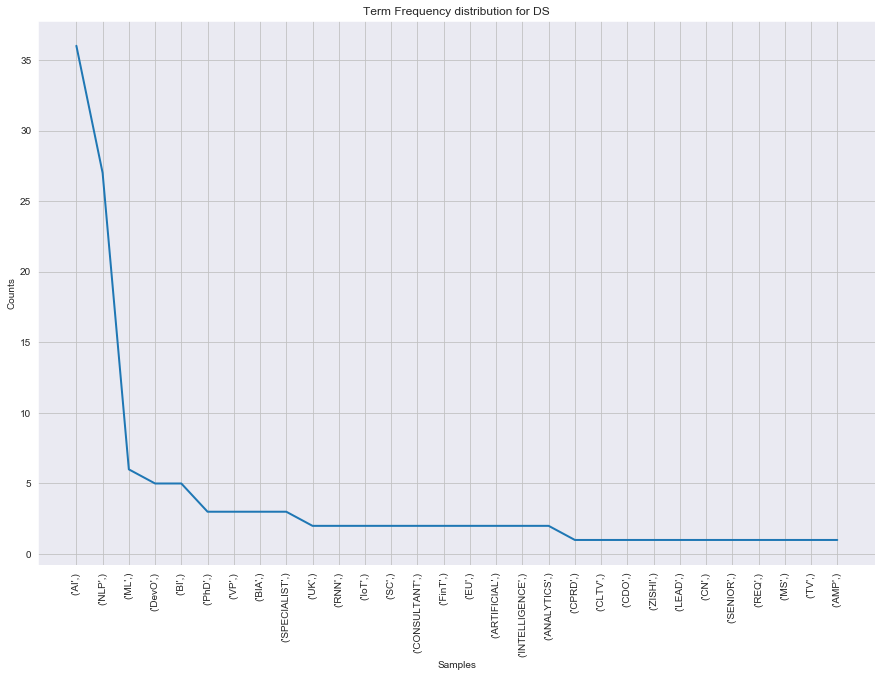

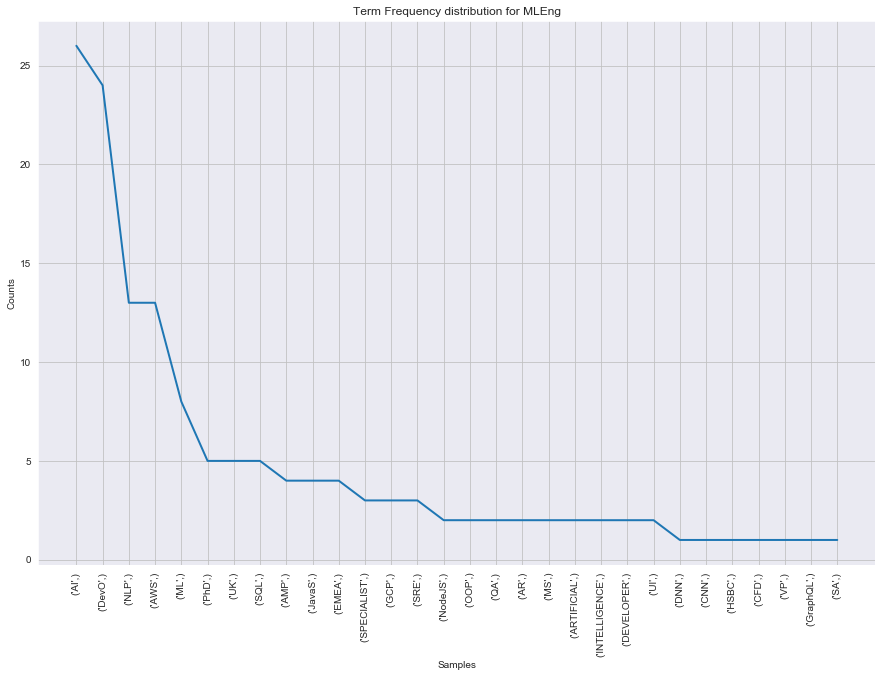

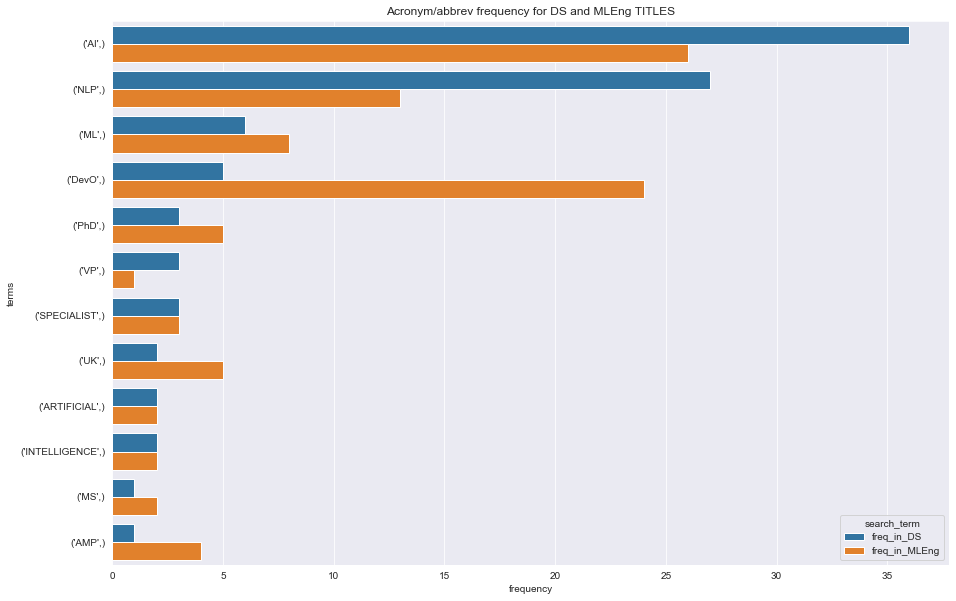

In [609]:

plot_df = fn.plot_term_bar('Acronym/abbrev frequency for DS and MLEng TITLES',
                           [df.loc[df.searched__data_scientist==1].job_title, df.loc[df.searched__data_scientist==0].job_title], ['DS', 'MLEng'],
                          RegexpTokenizer(r'[A-Z]+[a-zA-Z]*[A-Z]'), stop_word_lst, 'Acronym/abbreviation Frequency Distribution for words in descrs in DS jobs',
                             figsize=(15,10), num_terms=30, lower_case=False, ngram_number=1, save_fig=True, save_fig_name='acronyms_across_ds_and_ml_TITLES')


And finally, because we're sick of frequency distribution graphs, when we plot word clouds, we see the same trends - 'Senior' features more heavily in ML jobs --> it would be interesting to explore whether salaries also reflect this (see section 3 for more info).

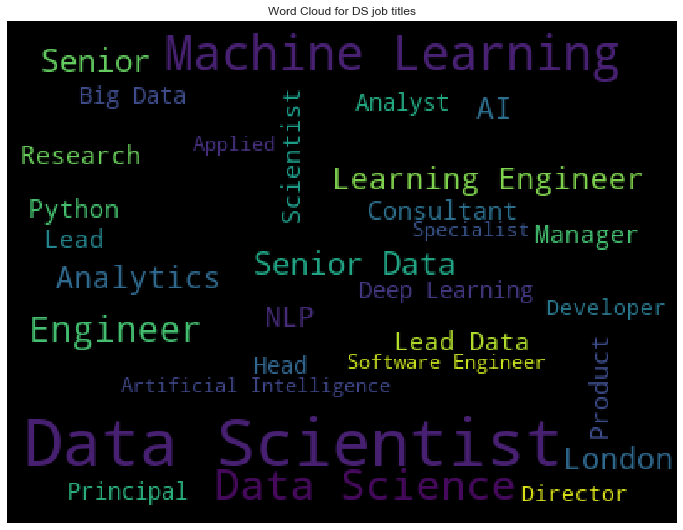

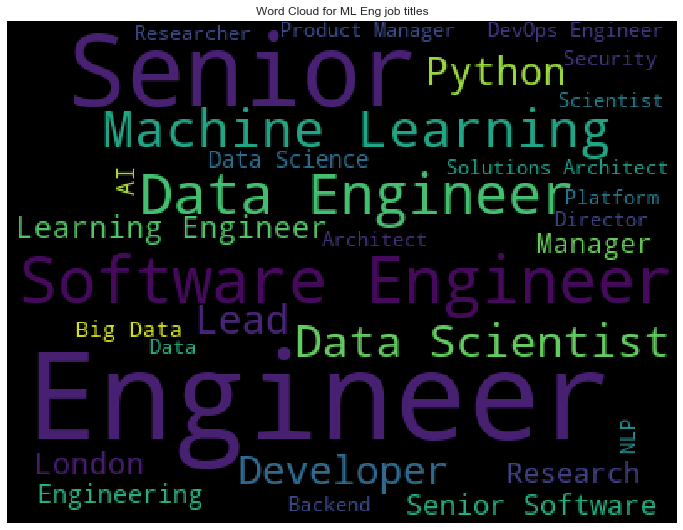

In [408]:
fn.gen_cloud(df.loc[df.searched__data_scientist==1].job_title, 30, cloud_title='Word Cloud for DS job titles')
fn.gen_cloud(df.loc[df.searched__data_scientist==0].job_title, 30, cloud_title='Word Cloud for ML Eng job titles')

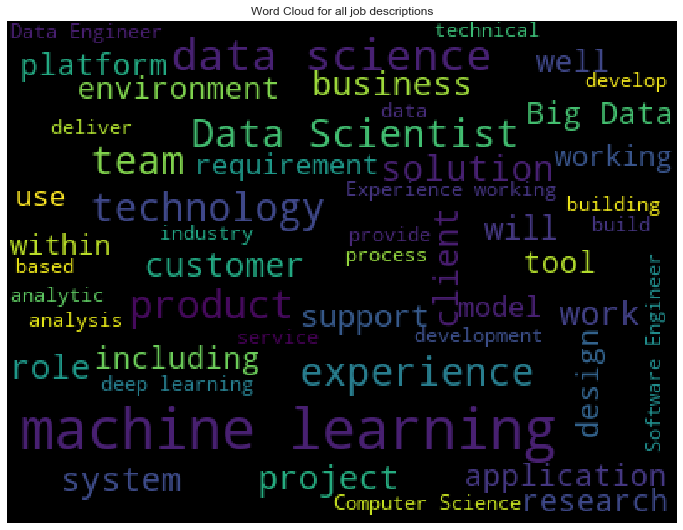

In [19]:
fn.gen_cloud(df.job_descr, 50, cloud_title='Word Cloud for all job descriptions')

<a id=one ><a/> 

## 2. Text EDA of both categories
    
[LINK to table of contents](#contents)

Now we get into the meat of the text - the job descriptions. I've done the same exploration as for titles in the same order, except I've filtered out stopwords more frequently, due to the nature of the description text. 

Most surprising is how often 'team' comes up and perhaps this reflects the need for DS's and MLEng's to work together and operate well with other employees. 

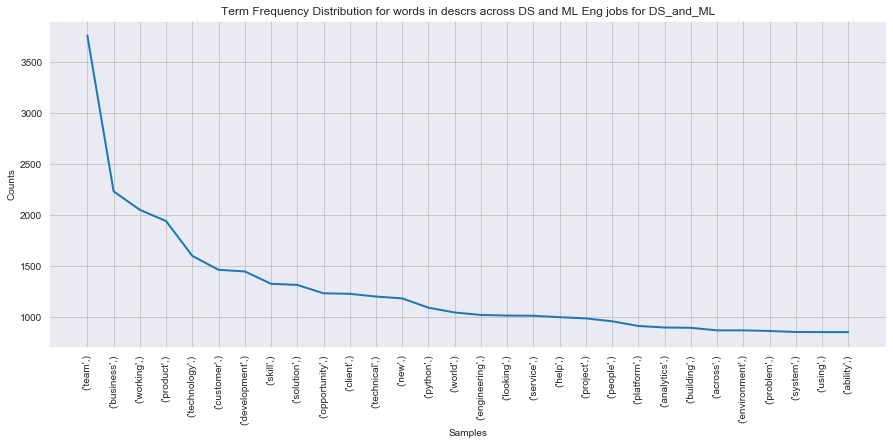

Text(0.5, 1.0, 'Trigrams across both jobs')

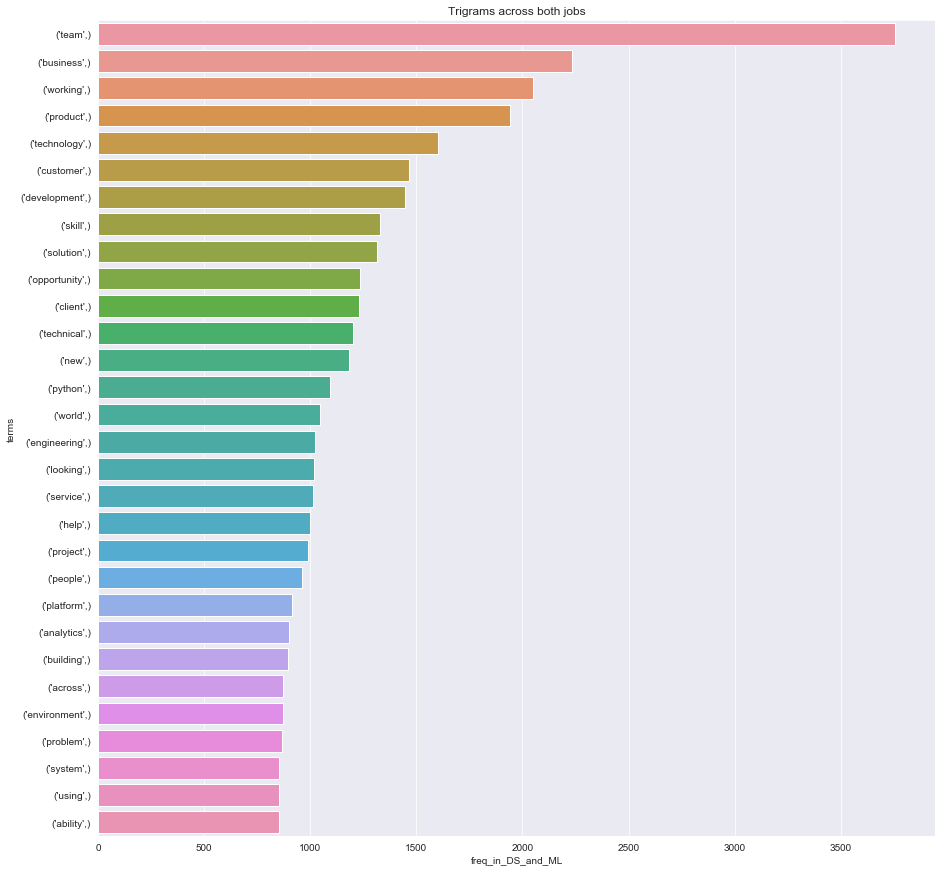

In [605]:
plot_df = fn.get_top_n_df([df.job_descr],['DS_and_ML'], tokenizer, stop_word_lst, 'Term Frequency Distribution for words in descrs across DS and ML Eng jobs',
                             figsize=(15,6), num_terms=30, lower_case=True, ngram_number=1);

plt.figure(figsize=(15,15))
plot = sns.barplot(y = 'terms', x = 'freq_in_DS_and_ML', data=plot_df)  
plt.title('Trigrams across both jobs')

The bigrams we're seeing are a lot less frequent than the previous single terms, however quick inspection shows that a lot of them are the type we'd only see mentioned once in a job post - e.g. 'day holiday', 'around world' - over 10% of the job posts give an indication that the employers (or at the very least the HR teams that wrote these) seem to show off grandiose ambitions or want to be seen as globally competitive organisations with the staff to reflect that. 
At this point we can detect more interesting patterns in how companies market their job posts regarding equal employment. For instance:
 * 'sexual orientation' undoubtedly comes from the paragraph at the bottom of most posts where companies promote themselves as an equal opportunity employer - it's only registering at around 140, less than 15% of job posts
 * 'equal opportunity' similarly only comes in about 125 times in this list - the majority of jobs aren't advertising themselves as that. 
 
An important thing to note that a company that DOES promote itself as this doesn't *necessarily* follow through on that AND vice versa, that a company not advertising themselves as such, isn't an unfair employeer. If you want to look at a more indicative measure of how many employeers are fair based on an arguably more objective metric, please go to section 3. 

What this does indicate is that the majority of DS and MLeng jobs aren't seeing that as an important thing to mention in their job posts. This could be for a variety of reasons - e.g. being fair and undiscriminatory in hiring practices is already the _law_; it could be that some companies aren't that great at fair hiring practices; could be that some companies see it as a waste of text because actions speak louder than filler text copied from an HR template. We can't assume anything here, only that the writers of these posts _mostly_ choose not to include those kind of statements. 

Another noteworthy bigram is 'flexible working' appearing in just under 19% of job posts - if around 1 in 5 jobs ONLY mentions that (and we see no mention of 'remote work') then how much has the job market changed for these jobs post-lockdown? How much do they accommodate those who need flexible working?

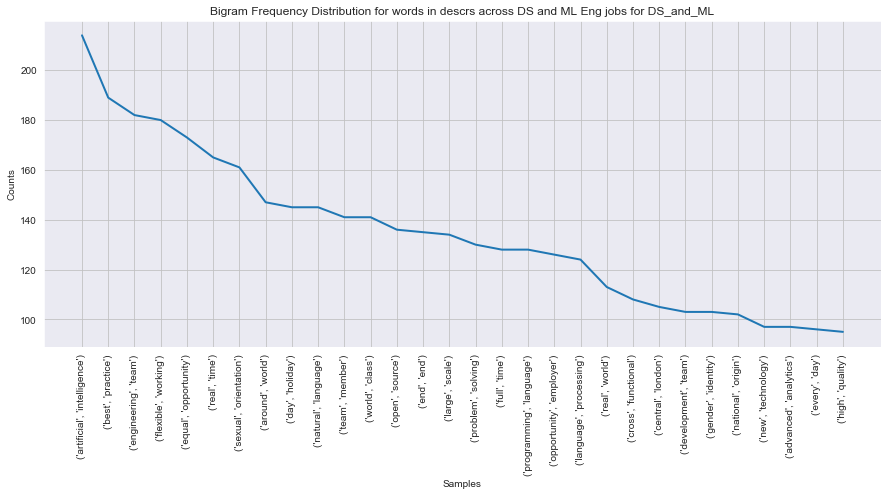

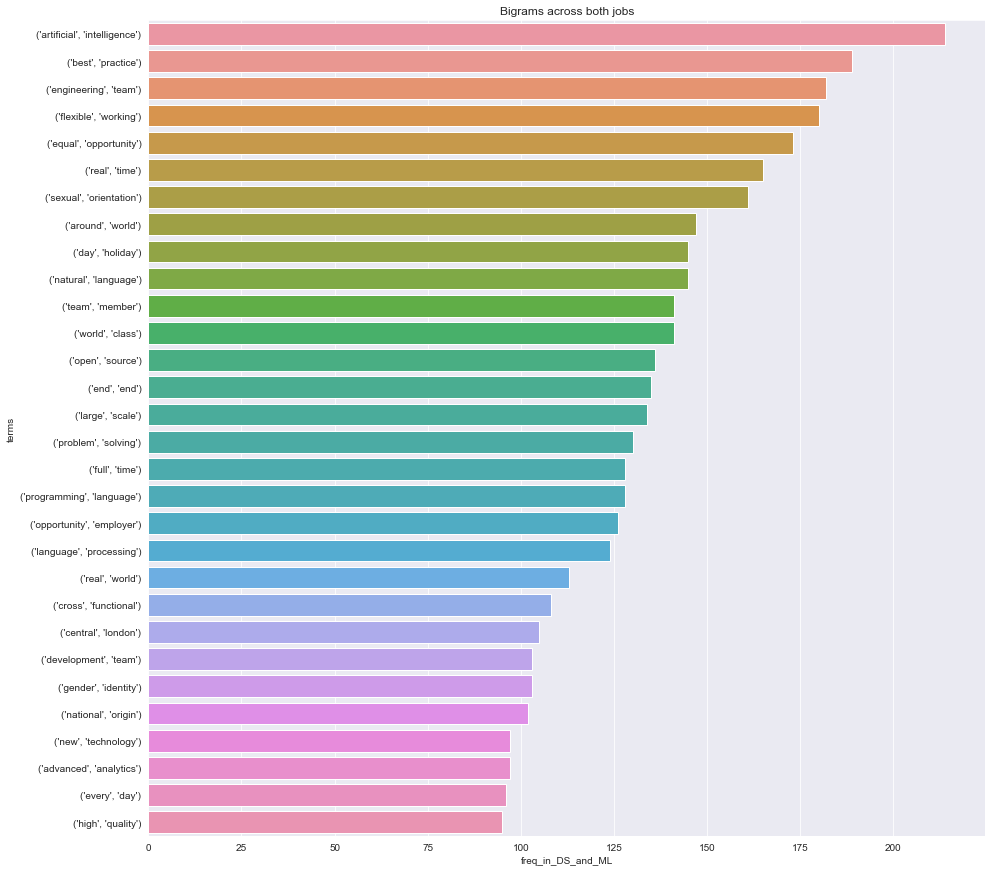

In [604]:
plot_df = fn.get_top_n_df([df.job_descr],['DS_and_ML'], tokenizer, stop_word_lst, 'Bigram Frequency Distribution for words in descrs across DS and ML Eng jobs',
                             figsize=(15,6), num_terms=30, lower_case=True, ngram_number=2);

plt.figure(figsize=(15,15))
plot = sns.barplot(y = 'terms', x = 'freq_in_DS_and_ML', data=plot_df )  
plt.title('Bigrams across both jobs');

As noted above, the equal employer flags do come up across a lot of job posts, but still it's just less than 10% of job posts, for potential reasons we discussed above. 
It's more interesting to note that AWS and NLP are finally coming up, in about 11-12% of job descriptions. The majority of jobs just aren't that concerened with those topics. Let's plot this again WITH the industry stopwords and see if we can catch more info. 

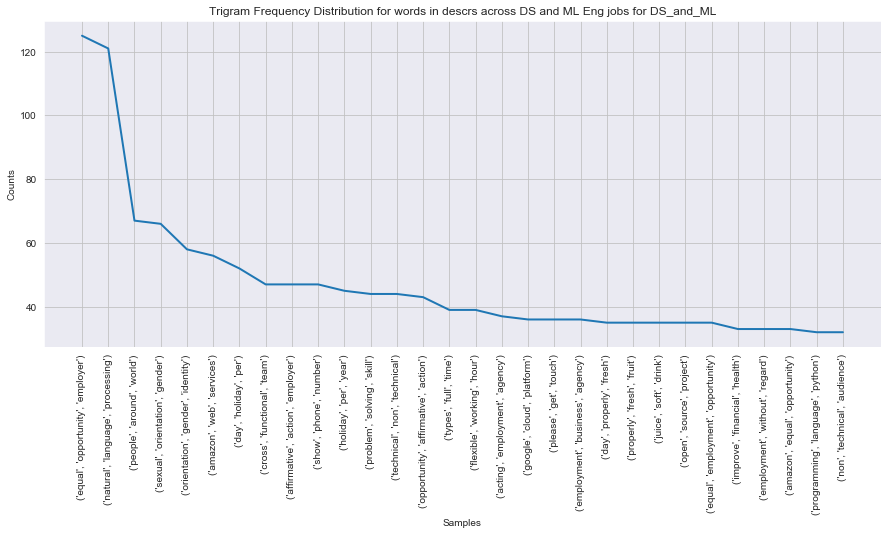

Text(0.5, 1.0, 'Trigrams across both jobs')

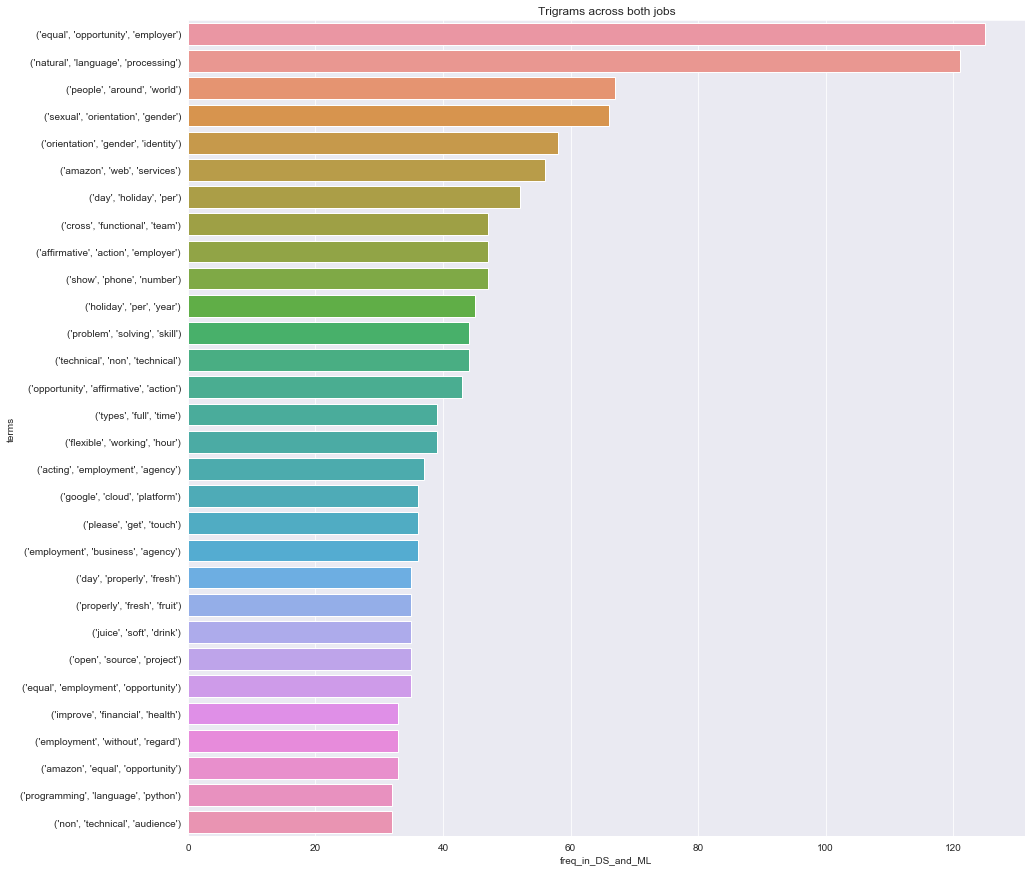

In [603]:
plot_df = fn.get_top_n_df([df.job_descr],['DS_and_ML'], tokenizer, stop_word_lst, 'Trigram Frequency Distribution for words in descrs across DS and ML Eng jobs',
                             figsize=(15,6), num_terms=30, lower_case=True, ngram_number=3);

plt.figure(figsize=(15,15))
plot = sns.barplot(y = 'terms', x = 'freq_in_DS_and_ML', data=plot_df )  
plt.title('Trigrams across both jobs')

The picture doesn't change that much, with ML models getting mentioned ~140 times. We should move to separate distributions for our job types and for acronyms/abbreviations.

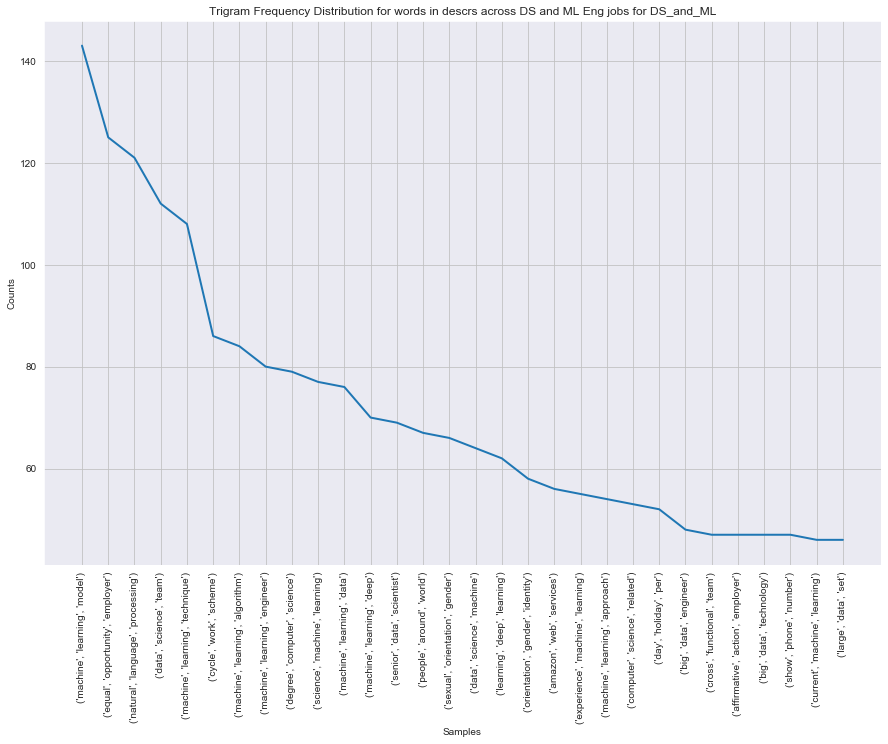

In [601]:
plot_df = fn.get_top_n_df([df.job_descr],['DS_and_ML'], tokenizer, stop_words, 'Trigram Frequency Distribution for words in descrs across DS and ML Eng jobs',
                             figsize=(15,10), num_terms=30, lower_case=True, ngram_number=3)

Text(0.5, 1.0, 'Trigrams across both jobs')

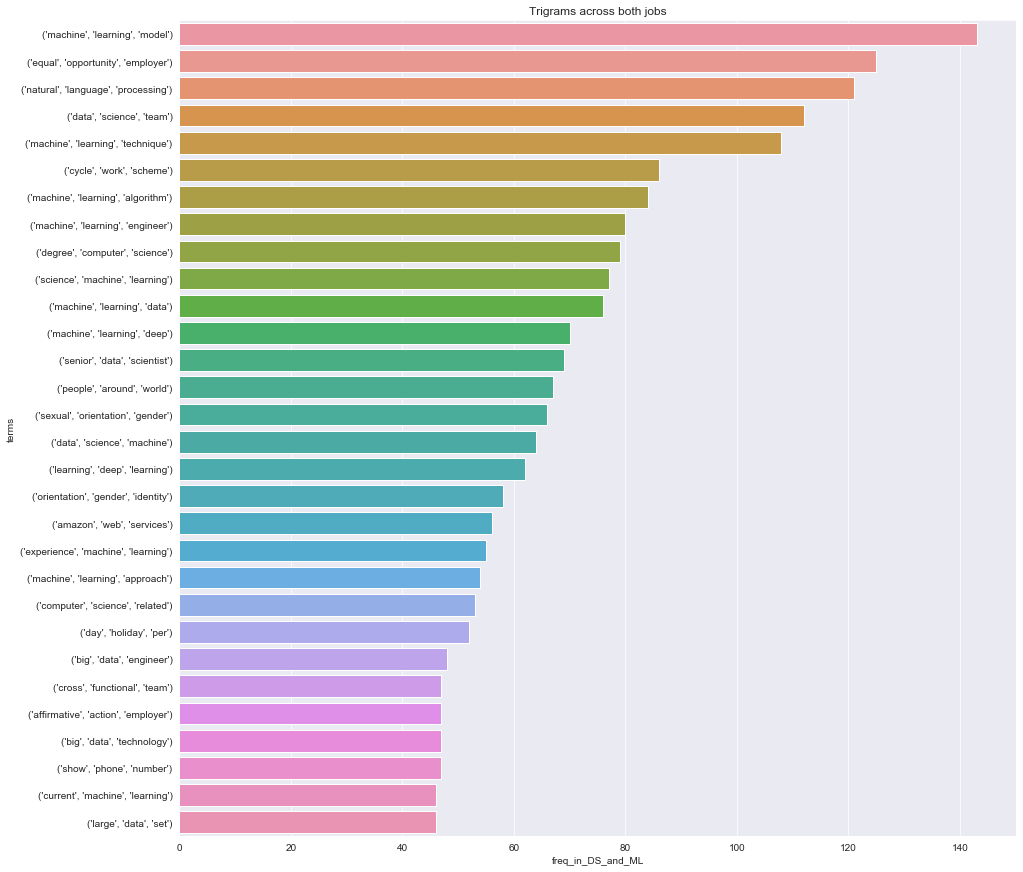

In [600]:
plt.figure(figsize=(15,15))
plot = sns.barplot(y = 'terms', x = 'freq_in_DS_and_ML', data=plot_df )  
plt.title('Trigrams across both jobs')

In [424]:
print('Total DS jobs     = ', len(df.loc[df.searched__data_scientist==1].job_descr))
print('Total ML Eng jobs = ', len(df.loc[df.searched__data_scientist==0].job_descr))

Total DS jobs     =  545
Total ML Eng jobs =  680


We can see that the team-work factor is still significant in both job posts. What about bigrams?

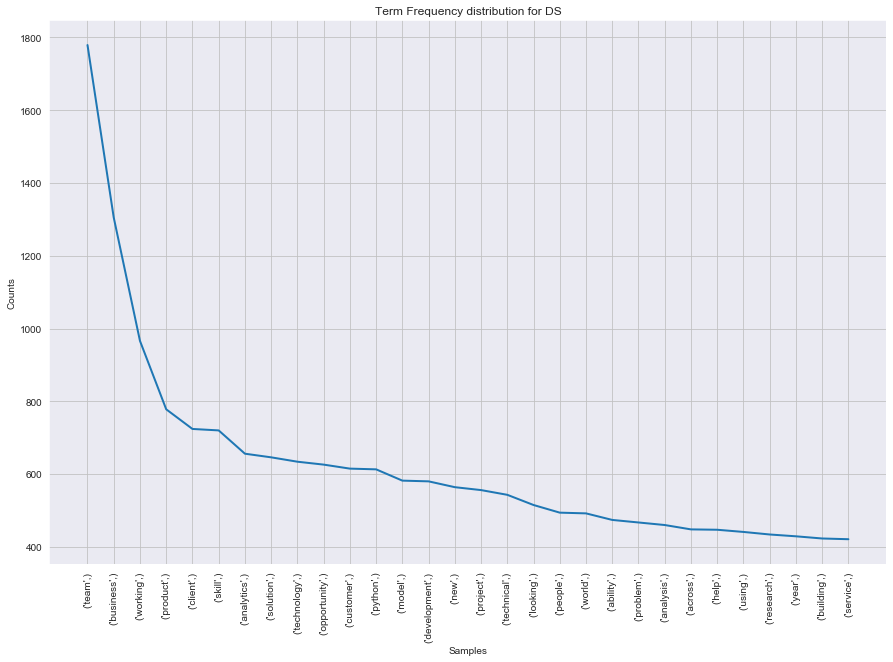

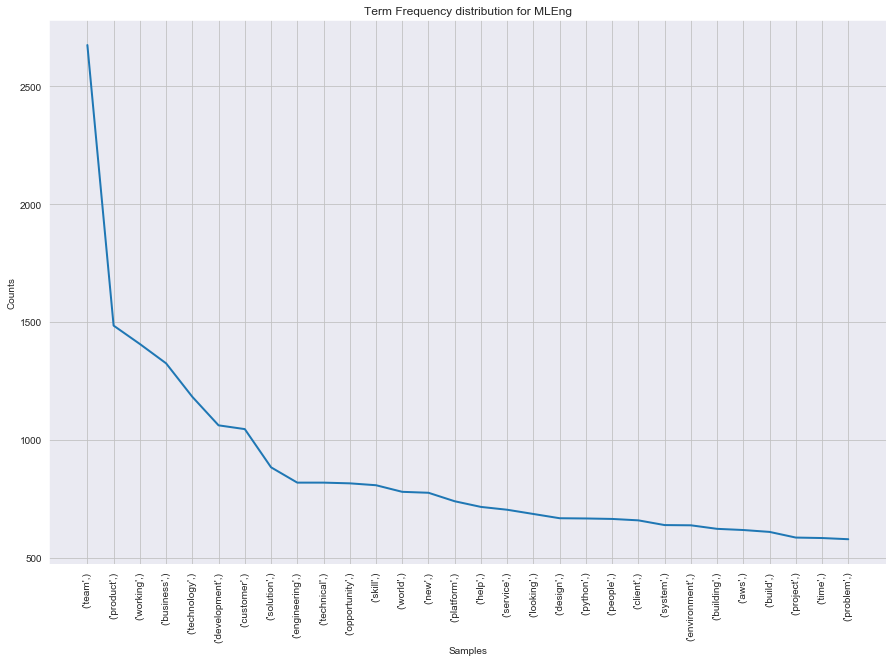

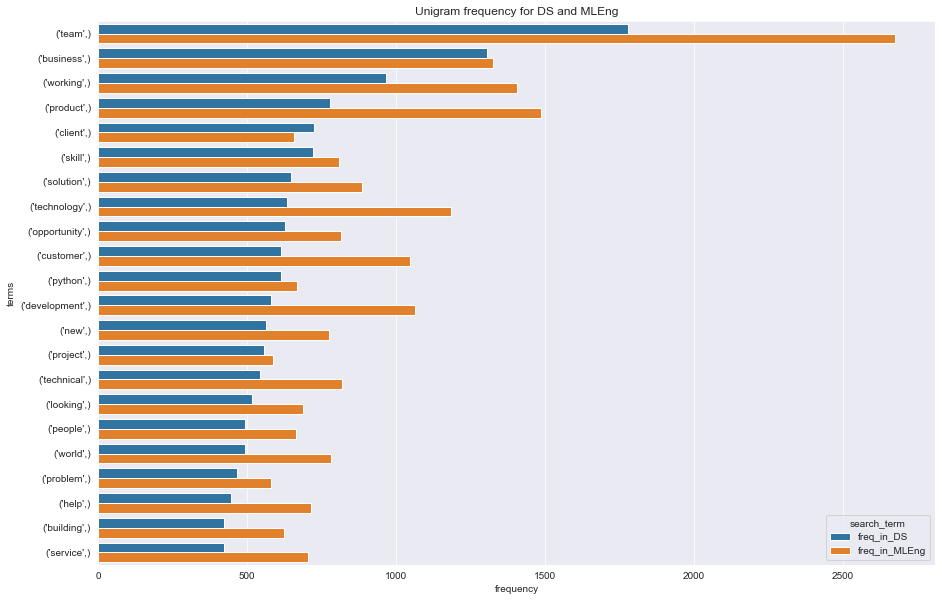

In [598]:
unigram_df = fn.plot_term_bar('Unigram frequency for DS and MLEng',
                           [df.loc[df.searched__data_scientist==1].job_descr, df.loc[df.searched__data_scientist==0].job_descr], ['DS', 'MLEng'],
                          tokenizer, stop_word_lst, 'Unigram Frequency Distribution for words in descrs in DS jobs w/out industry stopwords',
                             figsize=(15,10), num_terms=30, lower_case=True, ngram_number=1, save_fig=True, save_fig_name='unigrams_across_ds_and_ml_nosws')

The two categories diverge slightly here, with ML Eng having a stronger emphasis on 'best practice', 'large scale' and 'end \[to\] end' work. Both feature AI, although ML Eng slightly more.There are fewer clearer patterns across DS. Let's try this again with the industry stopwords included.

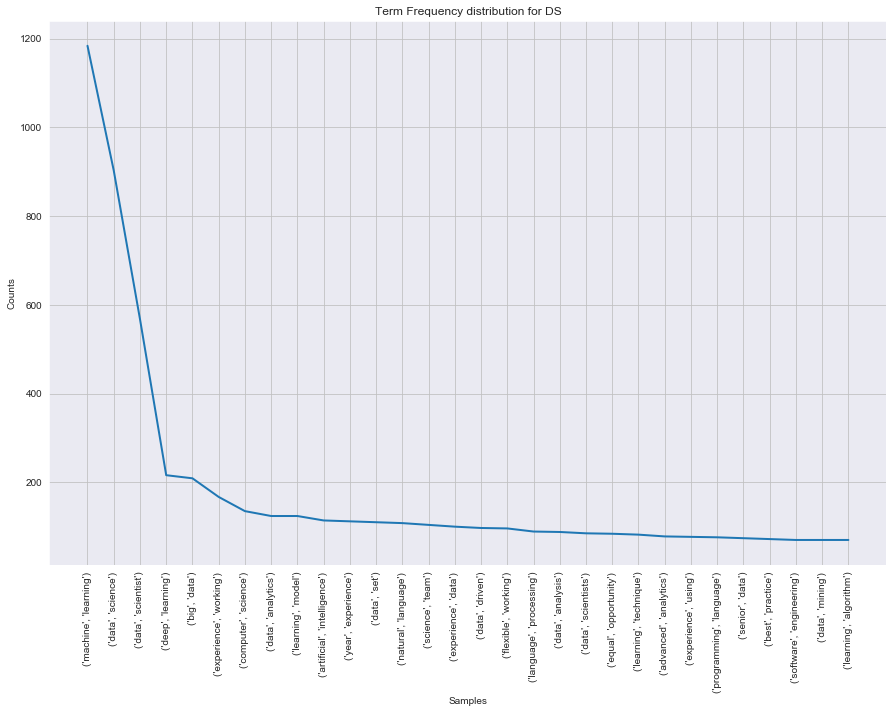

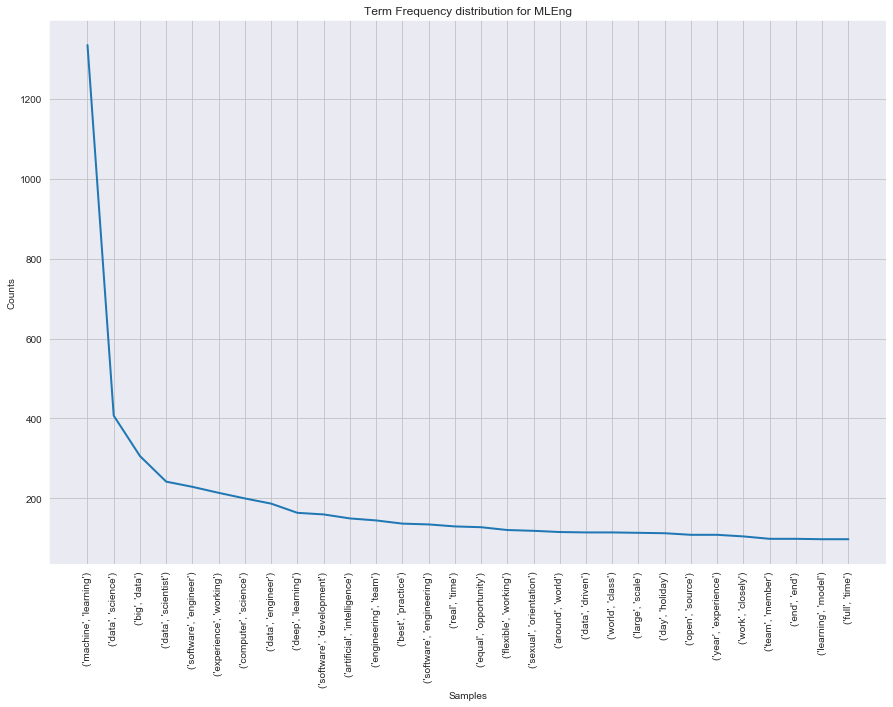

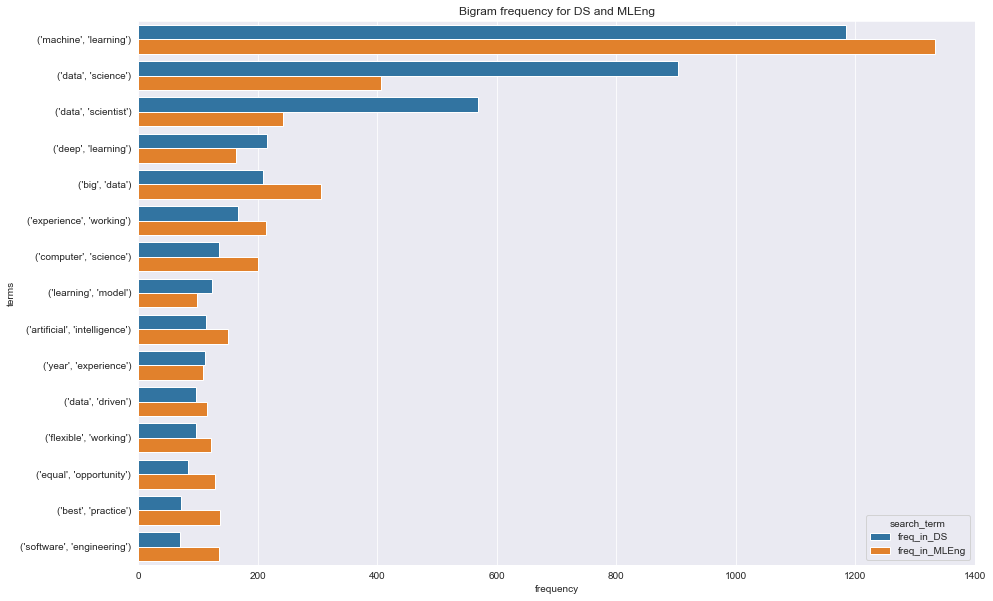

In [597]:
bigram_df = fn.plot_term_bar('Bigram frequency for DS and MLEng',
                           [df.loc[df.searched__data_scientist==1].job_descr, df.loc[df.searched__data_scientist==0].job_descr], ['DS', 'MLEng'],
                          tokenizer, stop_words, 'Bigram Frequency Distribution for words in descrs in DS jobs w/out industry stopwords',
                             figsize=(15,10), num_terms=30, lower_case=True, ngram_number=2, save_fig=True, save_fig_name='bigrams_across_ds_and_ml_nosws')

Putting industry stopwords back in has shown us :
* that it was a good idea to filter them out first (so many buzzwords, so little information) and
* that both types of job regularly involve using machine learning

It's surprising that 'deep learning' appears at similar frequencies in both types. This could be further speaking to the fact that the jobs have significant overlap. Onto trigrams!

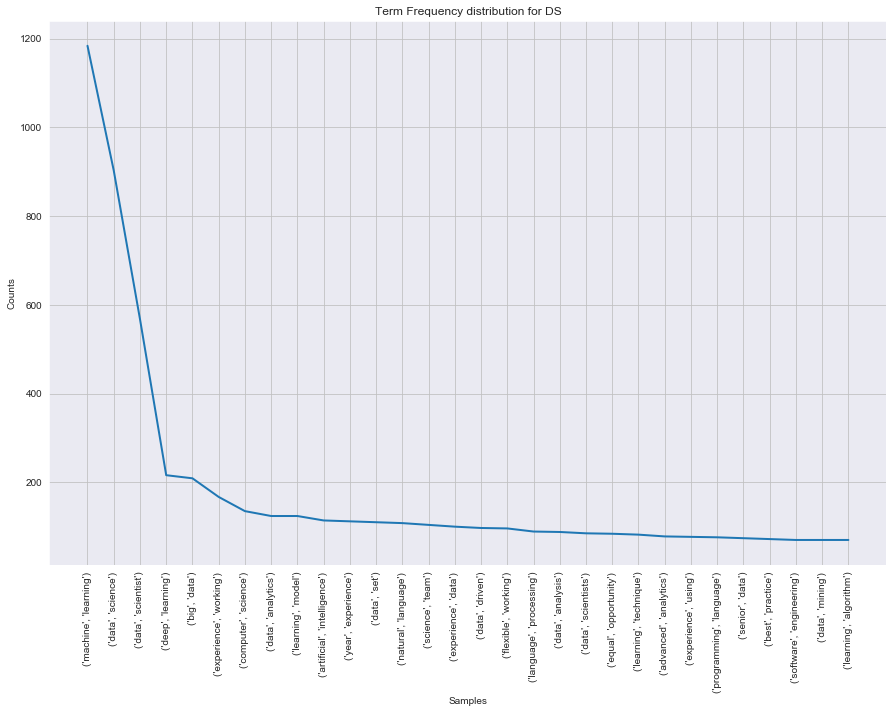

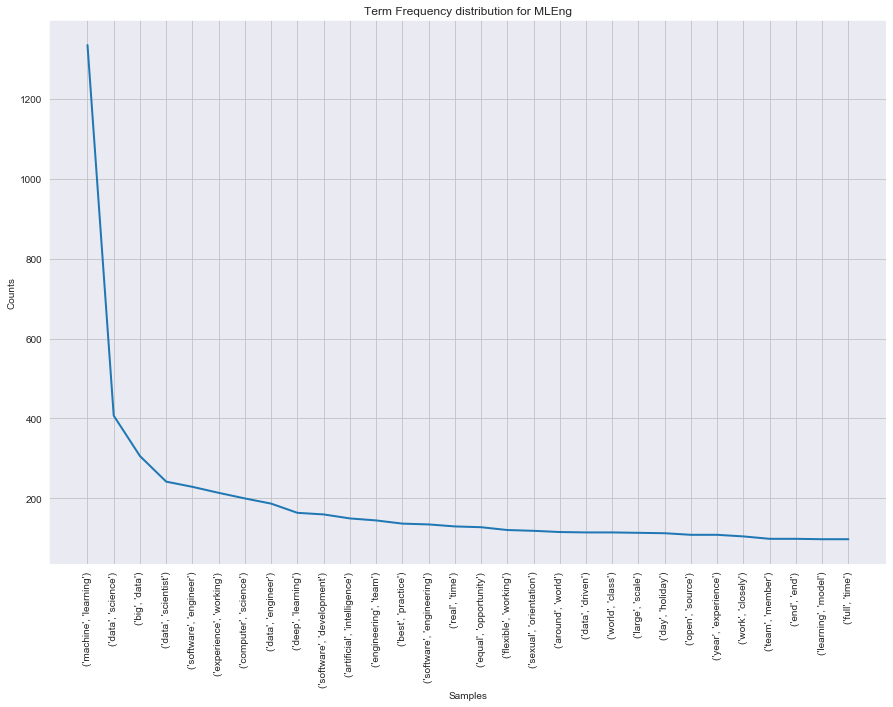

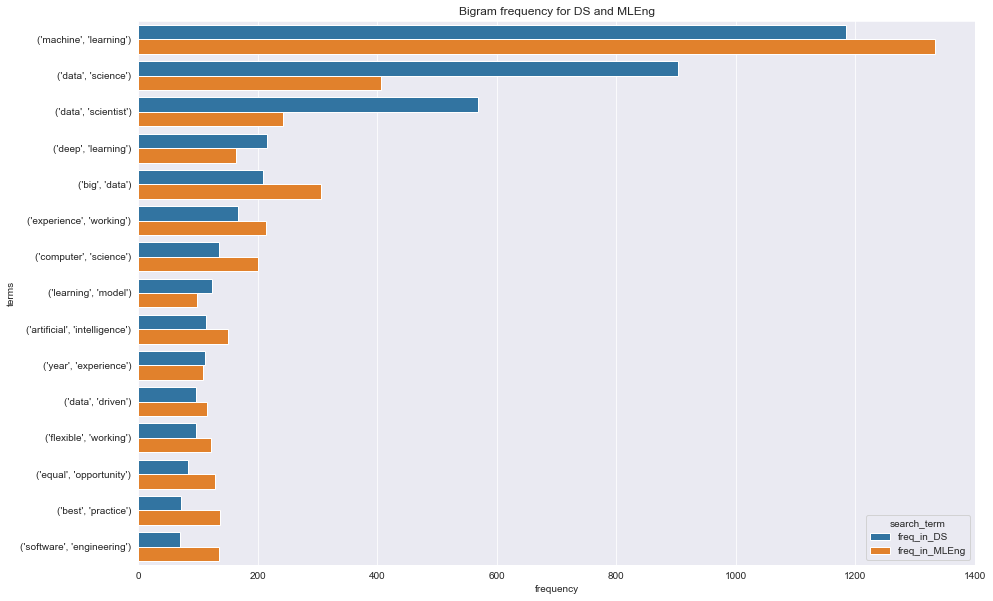

In [595]:
bigram_df = fn.plot_term_bar('Bigram frequency for DS and MLEng',
                           [df.loc[df.searched__data_scientist==1].job_descr, df.loc[df.searched__data_scientist==0].job_descr], ['DS', 'MLEng'],
                          tokenizer, stop_words, 'Bigram Frequency Distribution for words in descrs in DS jobs with industry stopwords',
                             figsize=(15,10), num_terms=30, lower_case=True, ngram_number=2, save_fig=True, save_fig_name='bigrams_across_ds_and_ml_wsws')

Straight off the bat from looking at the distributions we can see that the frequencies we're talking are moderately low, with the highest terms in both categoies only registering at about 15-20% and these being quite generic terms, like 'machine learning model'. At least that's a consistent trend in both categories. What about acronyms and abbreviations?

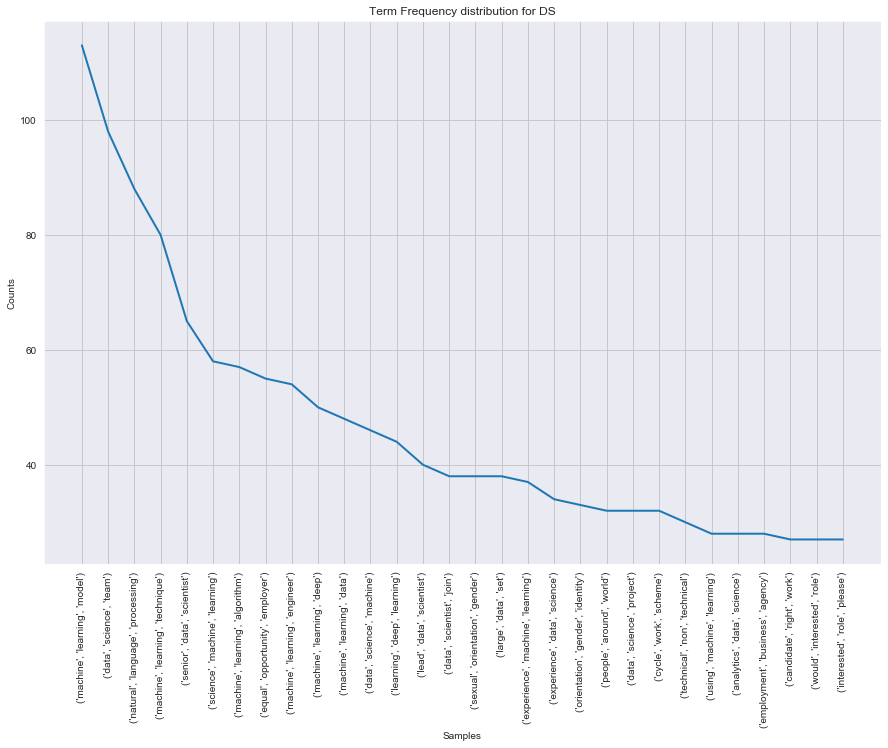

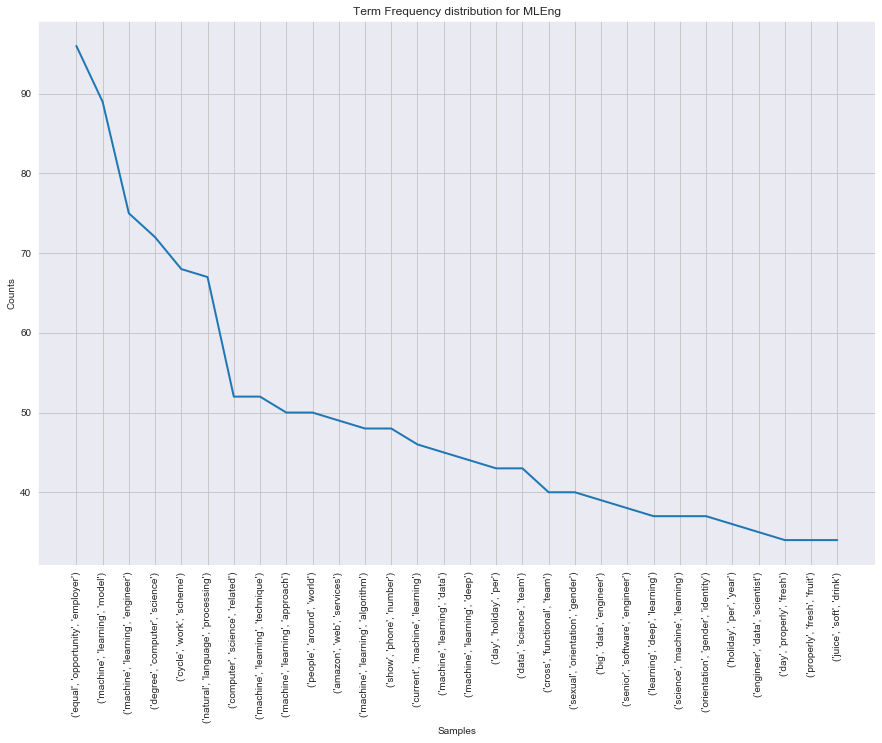

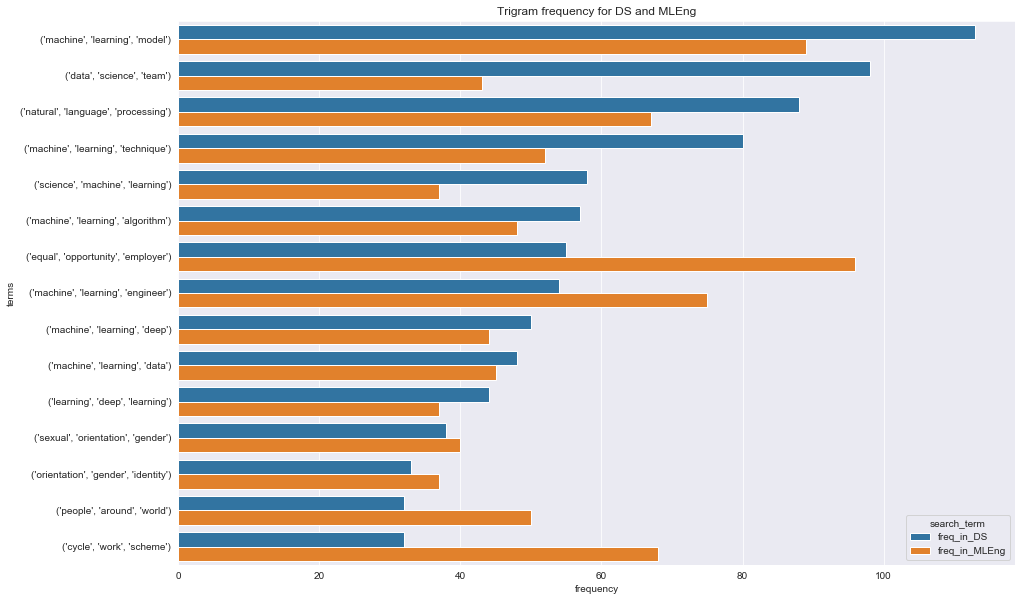

In [588]:
acr_df = fn.plot_term_bar('Trigram frequency for DS and MLEng',
                           [df.loc[df.searched__data_scientist==1].job_descr, df.loc[df.searched__data_scientist==0].job_descr], ['DS', 'MLEng'],
                          tokenizer, stop_words, 'Acronym/abbreviation Frequency Distribution for words in descrs in DS jobs',
                             figsize=(15,10), num_terms=30, lower_case=True, ngram_number=3, save_fig=True, save_fig_name='bigrams_across_ds_and_ml')


Now we're getting some more useful insight. 
* For a start, SQL is comparatively equal in both categories, i.e. around 40-45% of the data (assuming it's mentioned once per job post - and generally job posts don't have much reason to state it more than twice, but we can investigate that later). 
* If you're looking for DS jobs you'll benefit from cloud platform experience, what with AWS and GCP coming up, HOWEVER if you're looking for ML Eng jobs you've VERY likely to be using / needing AWS, as it occurs over 600 times. We'll check later how often that actually is without repeats in the same job post, but it's a good start for further exploration. 
* NLP is almost twice as frequently mentioned in DS than in ML Eng - guess I won't be building NLP pipelines any time soon! It's hard to draw conclusions from this, but it's interesting that this occurs. Perhaps it'll come up again in later analysis.
* You'd suspect the ML Jobs might have to focus more on data extraction and databases, but the occurence of terms like 'NoSQL', 'ETL' and 'SQL' appearing similar (within 5% points) relative amounts makes doubt that presupposition. Having said that, remember that there also jobs that contain both data science and ML elements, partly because some companies advertise for both simultaneously. 

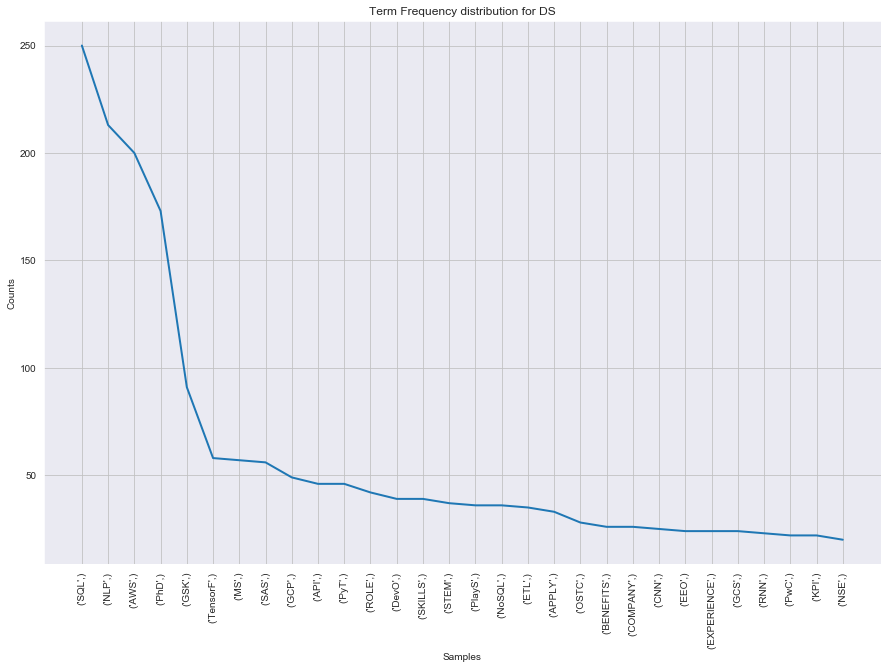

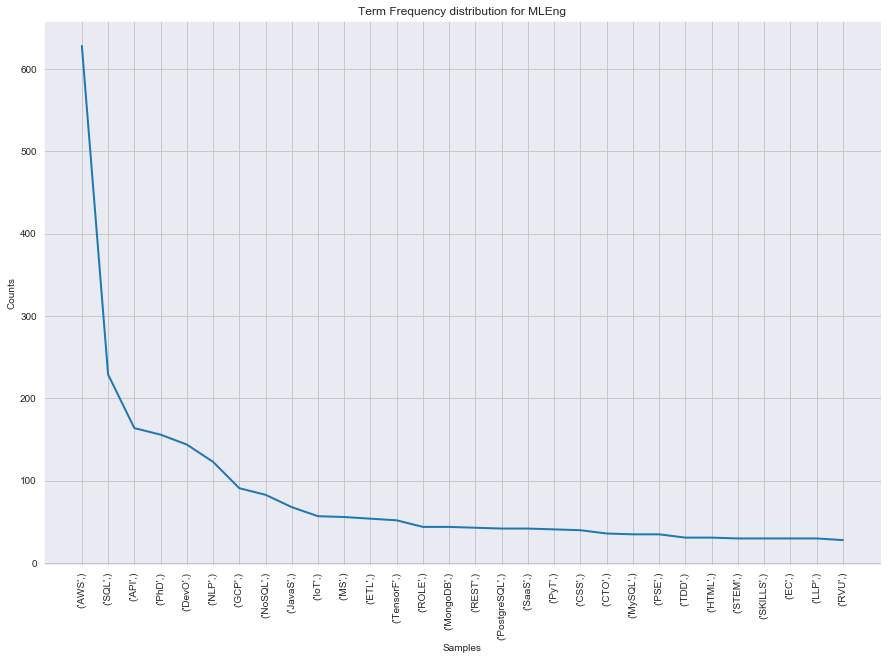

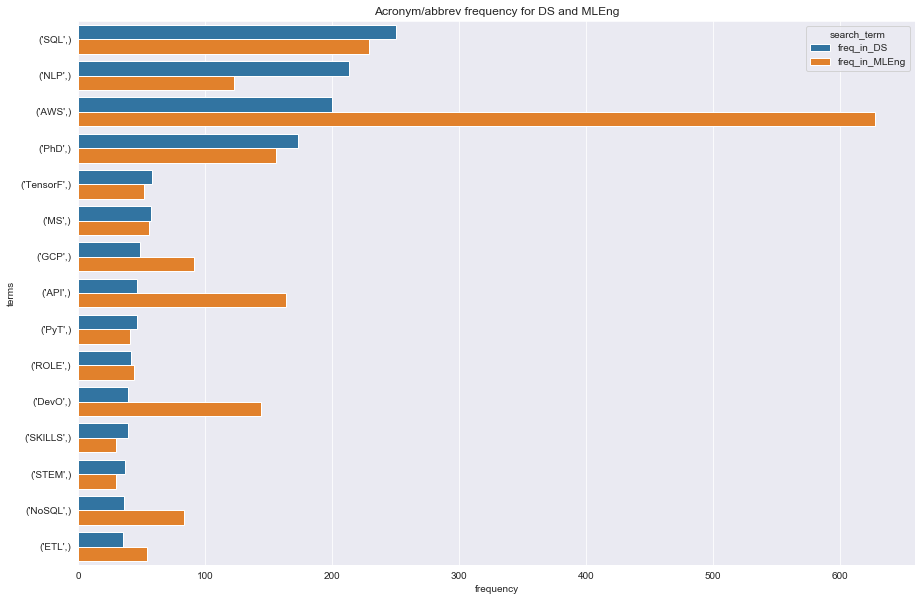

In [589]:
acr_df = fn.plot_term_bar('Acronym/abbrev frequency for DS and MLEng',
                           [df.loc[df.searched__data_scientist==1].job_descr, df.loc[df.searched__data_scientist==0].job_descr], ['DS', 'MLEng'],
                          RegexpTokenizer(r'[A-Z]+[a-zA-Z]*[A-Z]'), stop_words, 'Acronym/abbreviation Frequency Distribution for words in descrs in DS jobs',
                             figsize=(15,10), num_terms=30, lower_case=False, ngram_number=1, save_fig=True, save_fig_name='acronyms_across_ds_and_ml')


So that's the first thing we want to check next, the actual number of job posts that contain AWS in them, for both DS and ML Eng. 

In [506]:
def check_for_str_count(input_str, strings = ['AWS', 'amazon web services', 'GCP', 'cloud', 'azure']):
    x = 0
    for string in strings:
        for token in input_str.split(' '):
            if token==string:
                x+=1
    return x

def check_for_one_str(input_str, strings = ['AWS', 'amazon web services', 'GCP', 'cloud', 'azure']):
    for string in strings:
        if string in input_str:
            return 1
        
    return 0

In [490]:
mleng_df.head()

,company,job_title,job_descr,job_url,searched__data_scientist,searched__machine_learning_engineer,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews,id,aws_mention
545,Spotify,Machine Learning Engineer – Search,The Personalization team make deciding what pl...,https://www.indeed.co.uk/rc/clk?jk=adc2d336aec...,0,1,NaN,NaN,NaN,59.0,545,1
546,Transformative AI,Research Scientist - Machine Learning,ABOUT TRANSFORMATIVEBorn out CERN and the Univ...,https://www.indeed.co.uk/company/Transformativ...,0,1,NaN,NaN,NaN,NaN,546,1
547,Echobox,Junior Machine Learning Engineer - London,Echobox ha access very large granular private ...,https://www.indeed.co.uk/rc/clk?jk=110484a7c65...,0,1,NaN,NaN,NaN,NaN,547,0
548,OakNorth Bank,"Engineer, Machine Learning",OakNorth the next generation and monitoring pl...,https://www.indeed.co.uk/rc/clk?jk=4c460bbd6a3...,0,1,NaN,NaN,NaN,NaN,548,0
549,NP Group,Machine Learning Scientist,Machine Learning Scientist London Investments ...,https://www.indeed.co.uk/rc/clk?jk=6f06b212bad...,0,1,100000.0,52.69,Y,NaN,549,0


In [488]:
mleng_df = df.loc[df.searched__data_scientist==0]
dscie_df = df.loc[df.searched__data_scientist==1]
mleng_df['aws_mention'] = mleng_df.job_descr.apply(check_for_one_str)
dscie_df['aws_mention'] = dscie_df.job_descr.apply(check_for_one_str)

print("% ML jobs that mention AWS is: ", round(100*mleng_df.aws_mention.sum()/len(mleng_df), 2))
print("% DS jobs AWS mention is:      ", round(100* dscie_df.aws_mention.sum()/len(dscie_df),2))


% ML jobs that mention AWS is:  32.65
% DS jobs AWS mention is:       20.0


In [491]:
mleng_df['aws_num_mention'] = mleng_df.job_descr.apply(check_for_str_count)
dscie_df['aws_num_mention'] = dscie_df.job_descr.apply(check_for_str_count)

In [494]:
print('The mean number of times an ML job post mentions AWS is {}'.format(round(mleng_df.aws_num_mention.mean(),3)))
print('The mean number of times an DS job post mentions AWS is {}'.format(round(dscie_df.aws_num_mention.mean(),3)))

The mean number of times an ML job post mentions AWS is 0.909
The mean number of times an DS job post mentions AWS is 0.365


In [500]:
print('Excluding posts that DON\'T mention AWS, the mean number of times an ML job post mentions AWS is {}'.format(round(mleng_df.loc[mleng_df.aws_mention==1].aws_num_mention.mean(),3)))
print('Excluding posts that DON\'T mention AWS, the mean number of times an DS job post mentions AWS is {}'.format(round(dscie_df.loc[dscie_df.aws_mention==1].aws_num_mention.mean(),3)))

Excluding posts that DON'T mention AWS, the mean number of times an ML job post mentions AWS is 2.784
Excluding posts that DON'T mention AWS, the mean number of times an DS job post mentions AWS is 1.826


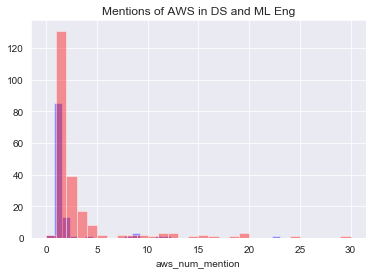

In [485]:
plt.title('Mentions of AWS in DS and ML Eng')
sns.distplot(dscie_df.loc[dscie_df.aws_mention==1].aws_num_mention, color='b', label = 'Data Sci', kde=False, bins=30)
sns.distplot(mleng_df.loc[mleng_df.aws_mention==1].aws_num_mention, color='r', label = 'ML Eng', kde=False, bins=30)

In [507]:
mleng_df['Cloud_mention'] = mleng_df.job_descr.apply(check_for_one_str)
dscie_df['Cloud_mention'] = dscie_df.job_descr.apply(check_for_one_str)

print("% ML jobs that mention any cloud services is: ", round(100*mleng_df.aws_mention.sum()/len(mleng_df), 2))
print("% DS jobs that mention any cloud services is: ", round(100* dscie_df.aws_mention.sum()/len(dscie_df),2))


% ML jobs that mention any cloud services is:  32.65
% DS jobs that mention any cloud services is:  20.0


In [508]:
mleng_df['cloud_num_mention'] = mleng_df.job_descr.apply(check_for_str_count)
dscie_df['cloud_num_mention'] = dscie_df.job_descr.apply(check_for_str_count)

print('Excluding posts that DON\'T mention cloud services at all, the mean number of times an ML job post mentions cloud services is {}'.format(round(mleng_df.loc[mleng_df.Cloud_mention==1].cloud_num_mention.mean(),3)))
print('Excluding posts that DON\'T mention cloud services at all, the mean number of times an DS job post mentions cloud services is {}'.format(round(dscie_df.loc[dscie_df.Cloud_mention==1].cloud_num_mention.mean(),3)))

Excluding posts that DON'T mention cloud services at all, the mean number of times an ML job post mentions cloud services is 3.387
Excluding posts that DON'T mention cloud services at all, the mean number of times an DS job post mentions cloud services is 2.222


And finally we plot word clouds.

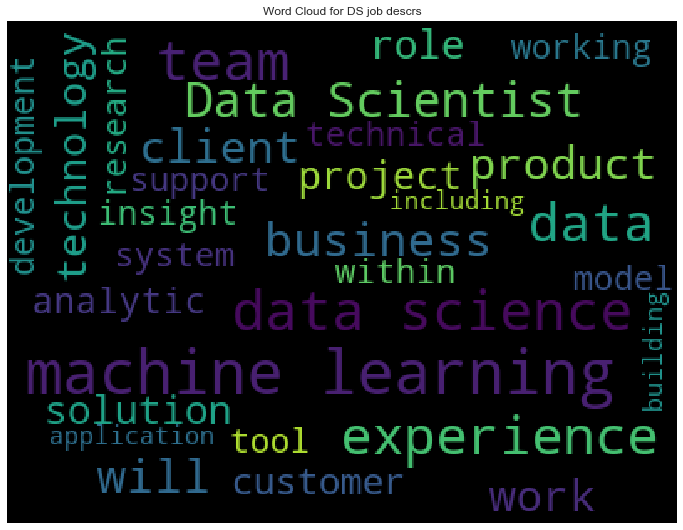

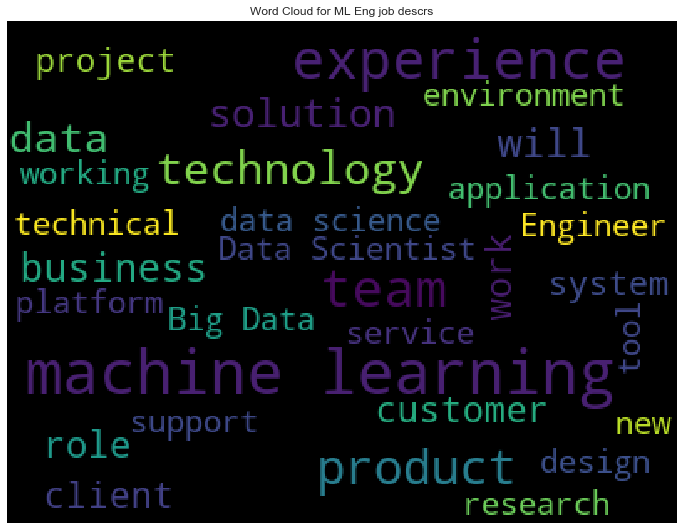

In [445]:
fn.gen_cloud(df.loc[df.searched__data_scientist==1].job_descr, 30, cloud_title='Word Cloud for DS job descrs')
fn.gen_cloud(df.loc[df.searched__data_scientist==0].job_descr, 30, cloud_title='Word Cloud for ML Eng job descrs')

<a id=two ><a/> 

## 3. EDA for salary data
    
[LINK to table of contents](#contents)

How many jobs actually advertise their salary? If our data is representative, then this is not a pretty sight:


In [513]:
print('The percentage of jobs in our sample that openly state any kind of salary range is {}'.format(round(100* len(df.loc[~df.salary_from_page_source_as_stated.isna()])/len(df),2)))

The percentage of jobs in our sample that openly state any kind of salary range is 34.37


In [523]:
print('The absolute nr of DS jobs in our sample that openly state any kind of salary range is     {}'.format((len(dscie_df.loc[~dscie_df.salary_from_page_source_as_stated.isna()]))))
print('The absolute nr of ML Eng jobs in our sample that openly state any kind of salary range is {}'.format(len(mleng_df.loc[~mleng_df.salary_from_page_source_as_stated.isna()])))

The absolute nr of DS jobs in our sample that openly state any kind of salary range is     202
The absolute nr of ML Eng jobs in our sample that openly state any kind of salary range is 219


In [515]:
print('The percentage of DS jobs in our sample that openly state any kind of salary range is     {}'.format(round(100* len(dscie_df.loc[~dscie_df.salary_from_page_source_as_stated.isna()])/len(dscie_df),2)))
print('The percentage of ML Eng jobs in our sample that openly state any kind of salary range is {}'.format(round(100* len(mleng_df.loc[~mleng_df.salary_from_page_source_as_stated.isna()])/len(mleng_df),2)))

The percentage of DS jobs in our sample that openly state any kind of salary range is     37.06
The percentage of ML Eng jobs in our sample that openly state any kind of salary range is 32.21


In [517]:
print('The percentage of jobs in our sample that state any kind of salary range is {}'.format(round(100* len(df.loc[df.salary_from_page_source_time_period=='Y'])/len(df.loc[~df.salary_from_page_source_as_stated.isna()]),2)))

The percentage of jobs in our sample that state any kind of salary range is 90.74


In [518]:
df.salary_from_page_source_time_period.value_counts(True)

Y    0.909524
D    0.059524
W    0.023810
H    0.004762
M    0.002381
Name: salary_from_page_source_time_period, dtype: float64

In [519]:
mleng_df.salary_from_page_source_time_period.value_counts(True)

Y    0.917431
D    0.059633
W    0.022936
Name: salary_from_page_source_time_period, dtype: float64

In [520]:
dscie_df.salary_from_page_source_time_period.value_counts(True)

Y    0.900990
D    0.059406
W    0.024752
H    0.009901
M    0.004950
Name: salary_from_page_source_time_period, dtype: float64

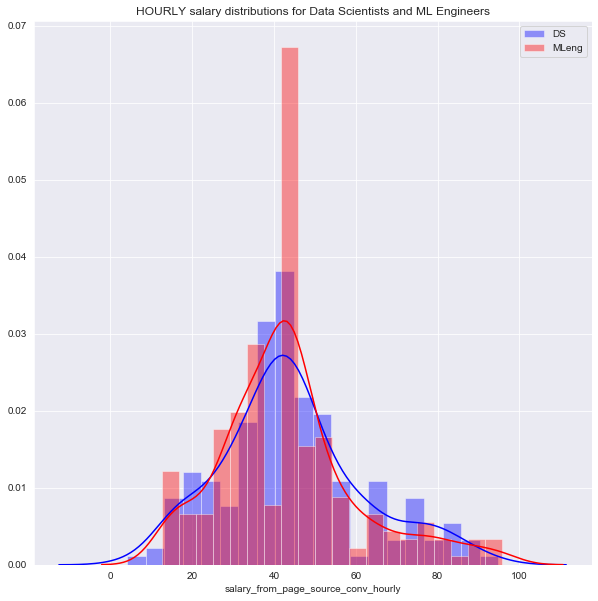

In [521]:
plt.figure(figsize=(10,10))
sns.distplot(df.loc[df['searched__data_scientist']==1].salary_from_page_source_conv_hourly, color='b', label='DS', bins=20)
sns.distplot(df.loc[df['searched__machine_learning_engineer']==1].salary_from_page_source_conv_hourly, color='r', label='MLeng', bins=20)
plt.title('HOURLY salary distributions for Data Scientists and ML Engineers')
plt.legend()
plt.savefig('salary_per_hour.jpeg')
plt.show();

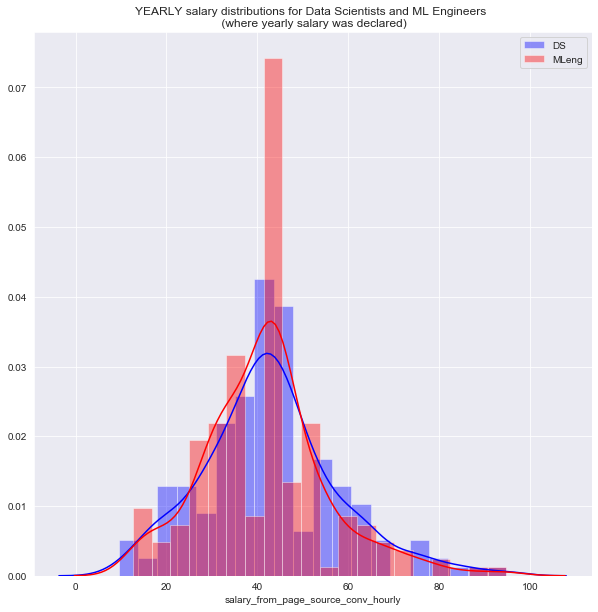

In [522]:
plt.figure(figsize=(10,10))
sns.distplot(df.loc[((df['searched__data_scientist']==1) & (df.salary_from_page_source_time_period=='Y'))].salary_from_page_source_conv_hourly, color='b', label='DS', bins=20)
sns.distplot(df.loc[((df['searched__machine_learning_engineer']==1) & (df.salary_from_page_source_time_period=='Y'))].salary_from_page_source_conv_hourly, color='r', label='MLeng', bins=20)
plt.title('YEARLY salary distributions for Data Scientists and ML Engineers \n (where yearly salary was declared)')
plt.legend()
plt.savefig('yearly_salary_dist.jpeg')
plt.show();

In [222]:
df.head()

,company,job_title,job_descr,job_url,searched__data_scientist,searched__machine_learning_engineer,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews,id
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,would like reassure all applicant that recruit...,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,1,0,39853.0,21.00,Y,18.0,0
1,PwC,Deals - Investigative Analytics - Data Scienti...,career within Forensics Technology service wil...,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,1,0,NaN,NaN,NaN,7678.0,1
2,Capital One - UK,Data Scientist - Cyber,White Collar Factory 95009 United Kingdom Lond...,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,1,0,NaN,NaN,NaN,8902.0,2
3,Globant,Lead Data Scientist,are digitally native technology where innovati...,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,1,0,NaN,NaN,NaN,NaN,3
4,UK Government - National Crime Agency,G4 Lead Data Scientist - Cyber,Deploy analytical capability support operation...,https://www.indeed.co.uk/rc/clk?jk=83ec2522af2...,1,0,35846.0,18.89,Y,32.0,4


In [241]:
comp_reviews = pd.DataFrame({'company':df.company, 'Num_reviews':df.Num_reviews})
comp_reviews = comp_reviews.drop_duplicates()

In [242]:
comp_reviews.tail()

,company,Num_reviews
1200,Square Enix,38.0
1209,Ravelin,NaN
1217,MyTutor,28.0
1220,Cytora,2.0
1224,Antidote,12.0


In [250]:
comp_reviews.describe()

,Num_reviews
count,180.000000
mean,7343.772222
std,18085.810643
min,2.000000
25%,8.000000
50%,98.000000
75%,2854.250000
max,61681.000000


In [255]:
comp_100 = comp_reviews.loc[comp_reviews.Num_reviews > 100].sort_values(by='Num_reviews', ascending=False)

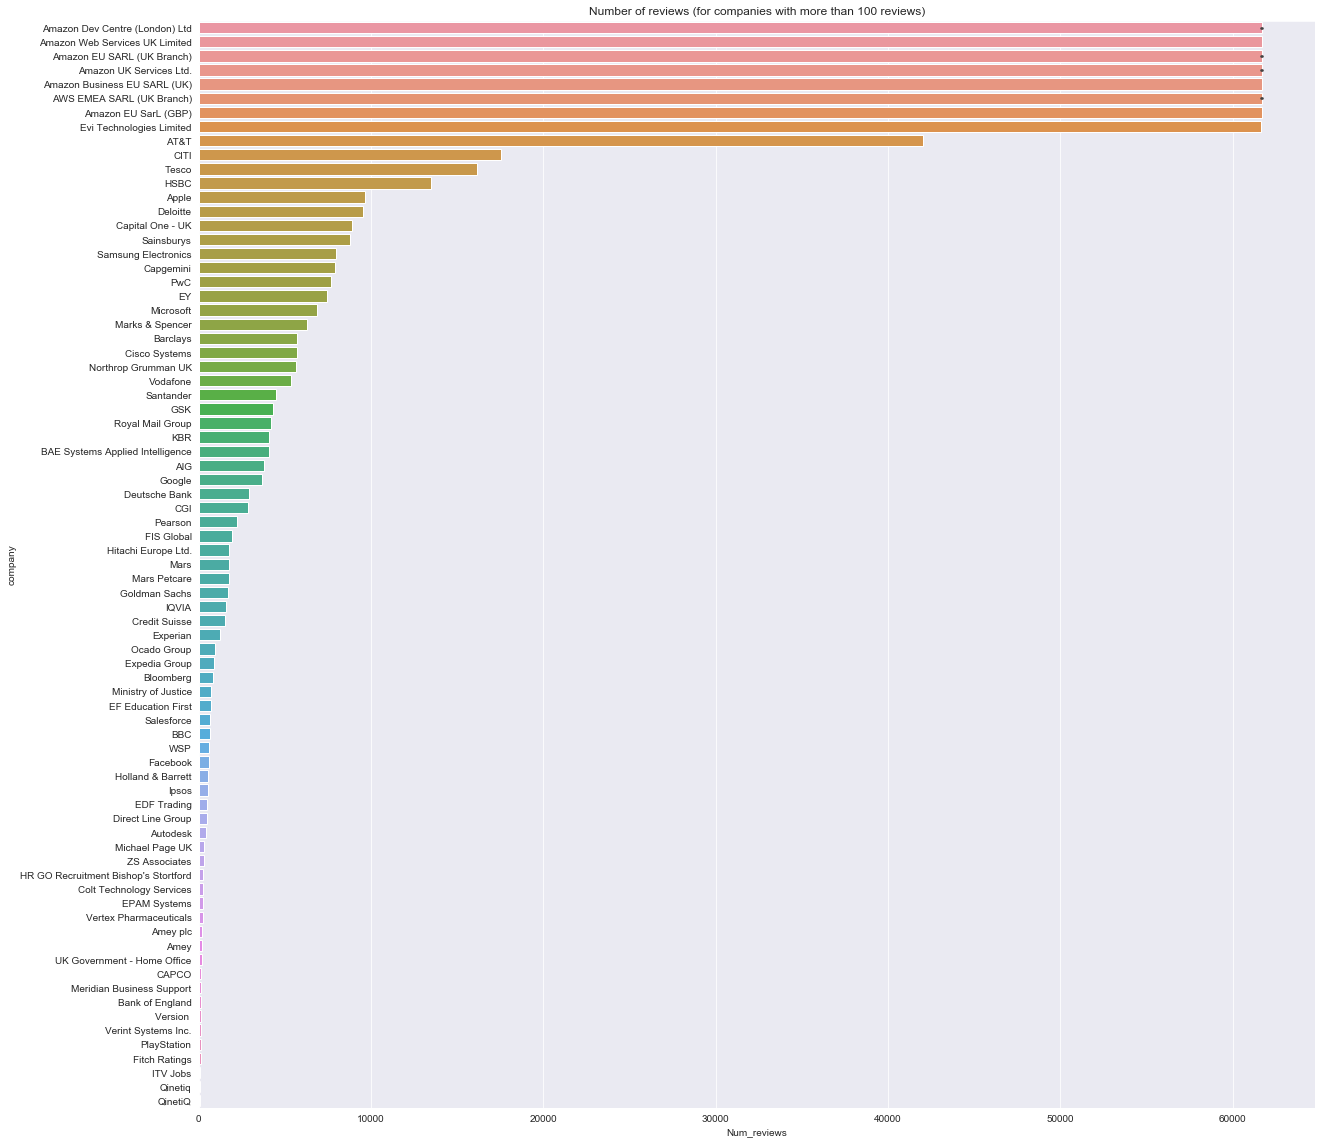

In [256]:
plt.figure(figsize=(20,20))
sns.barplot(comp_100.Num_reviews  , comp_100.company)
plt.title('Number of reviews (for companies with more than 100 reviews)')
plt.show();

<a id=three ><a/> 

## 4. Latent Semantic Analysis for exploration
    
[LINK to table of contents](#contents)

In [104]:
tf_idf_descr = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                         stop_words = stop_word_lst, ngram_range=(1,3),
                        max_df = 0.99,
                        min_df = 0.1)

tf_idf_titles = TfidfVectorizer(tokenizer=RegexpTokenizer(r'[A-Za-z]+').tokenize,
                         stop_words = None, ngram_range=(2,4),
                        max_df=0.95, min_df=0.005)



In [87]:
doc_term_matrix = tf_idf_descr.fit_transform(df.job_descr)

doc_term_df = pd.DataFrame(doc_term_matrix.toarray(), columns = tf_idf_descr.get_feature_names())

doc_term_df.head()

,2020,ability,able,academic,access,achieve,across,action,additional,advanced,...,way,web,well,within,working,world,world class,would,written,year
0,0.047394,0.000000,0.035310,0.0,0.048547,0.000000,0.027936,0.050519,0.000000,0.000000,...,0.036958,0.000000,0.059873,0.055420,0.056456,0.000000,0.0,0.070990,0.0,0.000000
1,0.000000,0.098851,0.042030,0.0,0.000000,0.000000,0.033252,0.000000,0.000000,0.088722,...,0.000000,0.000000,0.106903,0.164919,0.067201,0.091482,0.0,0.000000,0.0,0.000000
2,0.000000,0.054583,0.000000,0.0,0.000000,0.049326,0.082625,0.000000,0.000000,0.000000,...,0.036437,0.040524,0.000000,0.000000,0.129873,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.077790,...,0.000000,0.000000,0.000000,0.057839,0.078562,0.000000,0.0,0.074089,0.0,0.000000
4,0.049954,0.116707,0.074434,0.0,0.051169,0.000000,0.029444,0.000000,0.101882,0.000000,...,0.000000,0.000000,0.000000,0.058413,0.158680,0.000000,0.0,0.074824,0.0,0.056632


In [105]:
doc_term_titles_matrix = tf_idf_titles.fit_transform(df.job_title)

doc_term_titles_df = pd.DataFrame(doc_term_titles_matrix.toarray(), columns = tf_idf_titles.get_feature_names())

doc_term_titles_df.head()

,ai machine,ai machine learning,analytics manager,applied scientist,artificial intelligence,azure cloud,back end,backend engineer,big data,big data engineer,...,senior machine learning engineer,senior software,senior software engineer,site reliability,site reliability engineer,software developer,software development,software development engineer,software engineer,solutions architect
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
doc_term_titles_df['applied scientist'].sum()

5.11877085638471

In [111]:
for i, c in enumerate(doc_term_titles_df.columns):
    print(i, c, doc_term_titles_df[c].sum())

0 ai machine 5.042772743408616
1 ai machine learning 5.042772743408616
2 analytics manager 9.162551355234172
3 applied scientist 5.11877085638471
4 artificial intelligence 18.34443385345694
5 azure cloud 5.1188693635760165
6 back end 5.630056752379929
7 backend engineer 9.469069716835099
8 big data 25.944001021116833
9 big data engineer 9.859678080433383
10 business intelligence 5.9618434021965605
11 computer vision 11.56612760534263
12 consultant data 8.37392663122107
13 data analyst 10.343013470593167
14 data analytics 12.07802406908675
15 data engineer 57.50261233878961
16 data science 65.2941357797541
17 data science consultant 7.358437301732699
18 data science engineer 5.469685157334689
19 data scientist 203.82853718068412
20 data scientist london 5.052850708830352
21 data scientist machine 5.319860614570254
22 data scientist machine learning 4.696413892025843
23 data scientists 7.67259451311618
24 deep learning 20.500174892606434
25 development engineer 5.806186154261175
26 devop

In [180]:
lsa_obj = TruncatedSVD(n_components=10, n_iter=1000, random_state=22)

lsa_df = pd.DataFrame(lsa_obj.fit_transform(doc_term_df), 
                      columns = [f'Latent_concept_{x+1}' for x in range(lsa_obj.n_components)])
lsa_df.head()

,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9,Latent_concept_10
0,0.465279,-0.129586,0.019933,-0.147007,-0.066541,-0.002703,0.008919,-0.013888,0.066181,-0.064234
1,0.579206,-0.071877,-0.261666,-0.213866,0.018846,-0.138291,-0.131317,0.011711,-0.193732,0.055776
2,0.526933,-0.044721,-0.055872,0.049453,-0.027409,0.044609,-0.030755,-0.024991,0.105652,-0.067242
3,0.480220,-0.054542,-0.051680,-0.066270,-0.063895,-0.003679,0.022203,-0.035346,-0.055709,-0.031336
4,0.494409,-0.094503,-0.065994,-0.117283,0.045070,-0.067720,-0.089873,0.127211,0.047612,-0.088772


In [181]:
# sns.lineplot(range(len(lsa_obj.components_)), 
             
sum(lsa_obj.explained_variance_ratio_)

0.1841982813322035

In [182]:
V_T = lsa_obj.components_.T
V_T.shape

(448, 10)

In [183]:
term_topic_matrix = pd.DataFrame(data=V_T, 
                                 index = doc_term_df.columns, 
                                 columns = [f'Latent_concept_{x+1}' for x in range(lsa_obj.n_components)])

term_topic_matrix.head()

,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9,Latent_concept_10
2020,0.022462,0.041826,-0.000391,-0.004043,-0.025905,-0.020438,0.002104,0.005385,-0.044108,0.017670
ability,0.079005,-0.018367,-0.028414,-0.082694,0.021288,0.044556,0.058823,0.070150,0.079252,-0.060092
able,0.048057,-0.016127,-0.020976,-0.032916,-0.009216,-0.039735,-0.020161,0.011507,0.032984,-0.000154
academic,0.028036,-0.017252,0.046715,-0.041648,0.063290,0.016900,0.018173,-0.039626,0.001092,0.022376
access,0.021509,-0.001415,-0.006674,0.014209,0.010910,0.016671,-0.035492,0.022298,-0.004102,-0.011918


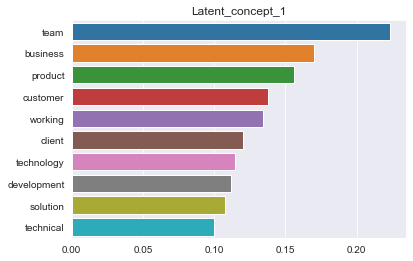

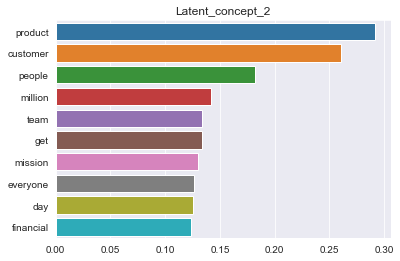

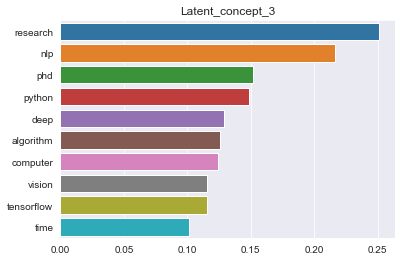

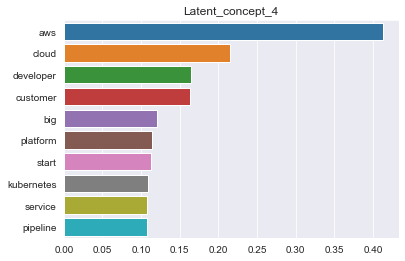

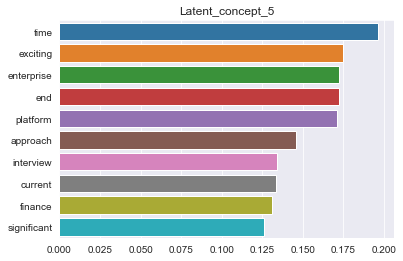

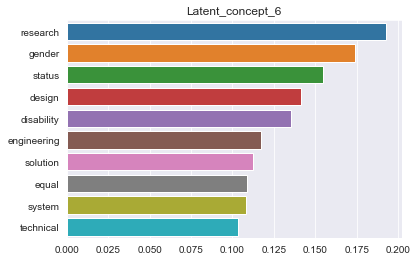

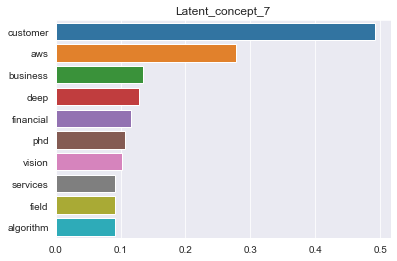

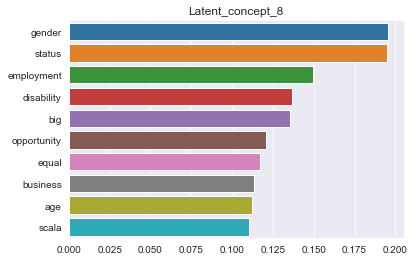

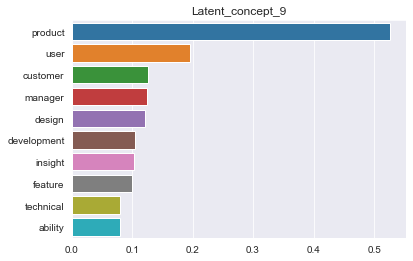

In [184]:
for i in range(1,10):
    data = term_topic_matrix[f'Latent_concept_{i}']
    data = data.sort_values(ascending=False)
    top_10 = data[:10]
    plt.title(f'Latent_concept_{i}')
    sns.barplot(y=top_10.index, x=top_10.values)
    plt.show()

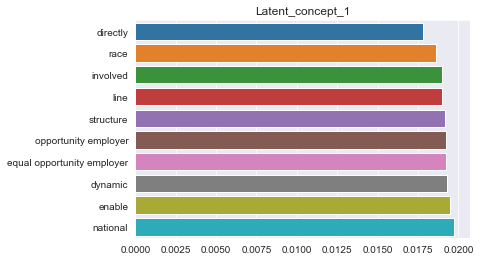

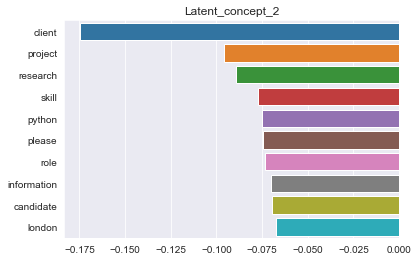

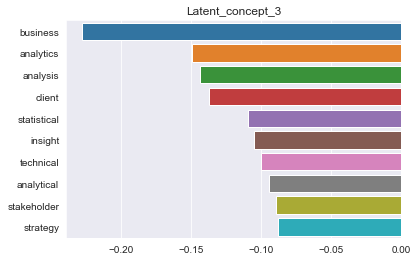

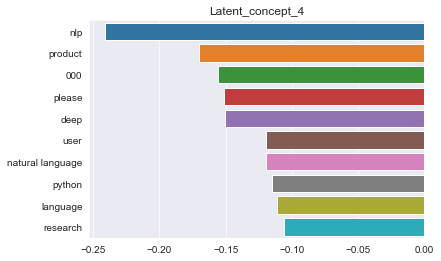

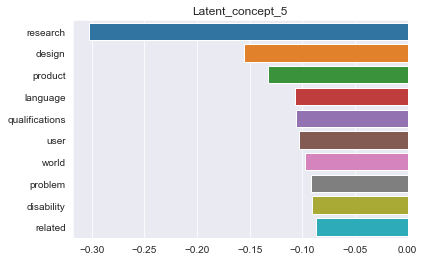

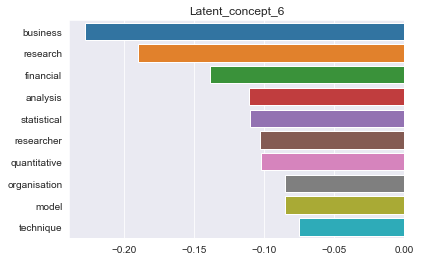

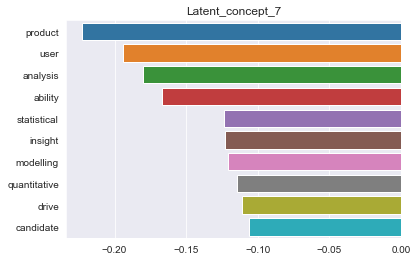

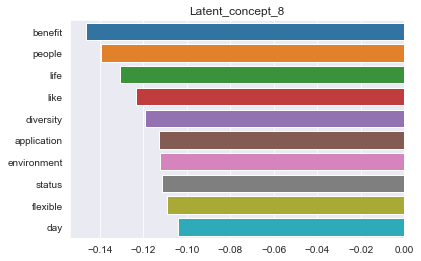

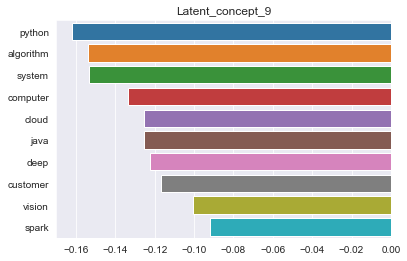

In [113]:
for i in range(1,10):
    data = term_topic_matrix[f'Latent_concept_{i}']
    data = data.sort_values(ascending=True)
    bottom_10 = data[:10]
    plt.title(f'Latent_concept_{i}')
    sns.barplot(y=bottom_10.index, x=bottom_10.values)
    plt.show()

In [161]:
train_doc_term_df, test_doc_term_df, train_target, test_target = train_test_split(lsa_df, df.searched__data_scientist, test_size=0.2, random_state=42)

In [196]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
x_train = minmax.fit_transform(X = train_doc_term_df)
x_test = minmax.transform(X = test_doc_term_df)

In [197]:
tree = DecisionTreeClassifier(min_samples_leaf=.1,
                              random_state=22)

tree.fit(x_train, train_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=22, splitter='best')

In [198]:
importances = tree.feature_importances_
feats = pd.DataFrame({'features': train_doc_term_df.columns, 'importance': importances})

feats.sort_values(by = 'importance',ascending=False, inplace=True)

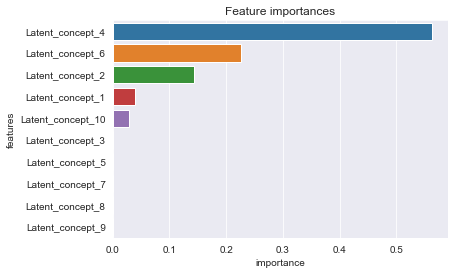

In [199]:
plt.figure()
plt.title("Feature importances")
sns.barplot(x=feats[:20].importance, y = feats[:20].features, orient='h')
plt.show()


In [201]:
accuracy_score(test_target, tree.predict(x_test))

0.673469387755102

In [150]:
import statsmodels.api as sm

In [206]:
input_data = sm.add_constant(x_train)

logit = sm.Logit(train_target, input_data)

logit_fit = logit.fit_regularized(alpha=0.1)

logit_fit.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5468069195189303
            Iterations: 174
            Function evaluations: 174
            Gradient evaluations: 174


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                              
====================================================================================
Dep. Variable:     searched__data_scientist   No. Observations:                  980
Model:                                Logit   Df Residuals:                      969
Method:                                 MLE   Df Model:                           10
Date:                      Sat, 06 Jun 2020   Pseudo R-squ.:                  0.2064
Time:                              14:54:52   Log-Likelihood:                -533.46
converged:                             True   LL-Null:                       -672.16
Covariance Type:                  nonrobust   LLR p-value:                 9.167e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4481      0.732      7.445      0.000       4.014       6.882
x1            -0.1468      0.573     -0.256      0.798      -1.271       0.977
x2            -2.6930      0.499     -5.395      0.000      -3.671      -1.715
x3            -0.8898      0.438     -2.032      0.042      -1.748      -0.031
x4            -5.0962      0.517     -9.851      0.000      -6.110      -4.082
x5            -2.1786      0.506     -4.305      0.000      -3.170      -1.187
x6            -4.2163      0.506     -8.328      0.000      -5.209      -3.224
x7             1.9401      0.519      3.738      0.000       0.923       2.957
x8            -0.4661      0.607     -0.768      0.442      -1.655       0.723
x9            -0.4937      0.529     -0.933      0.351      -1.531       0.544
x10            0.5543      0.497      1.115      0.265      -0.420       1.528
==============================================================================
"""

In [209]:
input_data_test = sm.add_constant(x_test)

In [212]:
accuracy_score(test_target, 
               logit_fit.predict(input_data_test).round())

0.6816326530612244

<a id=conc ><a/> 

## 4. Conclusions and ideas going forward
    
[LINK to table of contents](#contents)